In [1]:
import json
from sae_lens import SAE, HookedSAETransformer
from functools import partial
import einops
import os
import gc
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
from datasets import load_dataset
from transformers import AutoTokenizer
from transformer_lens.hook_points import (
    HookPoint,
) 
import numpy as np
import pandas as pd
from pprint import pprint as pp
from typing import Tuple
from torch import Tensor
from functools import lru_cache
from typing import TypedDict, Optional, Tuple, Union
from tqdm import tqdm
import random

In [2]:
with open("config.json", 'r') as file:
   config = json.load(file)
token = config.get('huggingface_token', None)
os.environ["HF_TOKEN"] = token

# Define device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

hf_cache = "/work/pi_jensen_umass_edu/jnainani_umass_edu/mechinterp/huggingface_cache/hub"
os.environ["HF_HOME"] = hf_cache

# Load the model
model = HookedSAETransformer.from_pretrained("google/gemma-2-9b", device=device, cache_dir=hf_cache) 

Device: cuda


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Loaded pretrained model google/gemma-2-9b into HookedTransformer


In [3]:
pad_token_id = model.tokenizer.pad_token_id
for param in model.parameters():
   param.requires_grad_(False)

device = "cuda"
layers= [7, 14, 21, 40]
l0s = [92, 67, 129, 125]
saes = [SAE.from_pretrained(release="gemma-scope-9b-pt-res", sae_id=f"layer_{layers[i]}/width_16k/average_l0_{l0s[i]}", device=device)[0] for i in range(len(layers))]

In [4]:
!nvidia-smi

Sat Dec 28 20:01:17 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.05             Driver Version: 550.127.05     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  |   00000000:9D:00.0 Off |                    0 |
| N/A   42C    P0             74W /  500W |   45027MiB /  81920MiB |      3%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


# utilities

In [6]:
def cleanup_cuda():
   torch.cuda.empty_cache()
   gc.collect()

def clear_memory():
   for sae in saes:
      for param in sae.parameters():
         param.grad = None
      for param in sae.mask.parameters():
         param.grad = None

   for param in model.parameters():
      param.grad = None
   cleanup_cuda()


In [7]:
cleanup_cuda()

# Mask

In [8]:
class SAEMasks(nn.Module):
    def __init__(self, hook_points, masks):
        super().__init__()
        self.hook_points = hook_points  # list of strings
        self.masks = masks

    def forward(self, x, sae_hook_point, mean_ablation=None):
        index = self.hook_points.index(sae_hook_point)
        mask = self.masks[index]
        censored_activations = torch.ones_like(x)
        if mean_ablation is not None:
            censored_activations = censored_activations * mean_ablation
        else:
            censored_activations = censored_activations * 0
        
        diff_to_x = x - censored_activations
        return censored_activations + diff_to_x * mask

    def print_mask_statistics(self):
        """
        Prints statistics about each binary mask:
          - total number of elements (latents)
          - total number of 'on' latents (mask == 1)
          - average on-latents per token
            * If shape == [latent_dim], there's effectively 1 token
            * If shape == [seq, latent_dim], it's 'sum of on-latents / seq'
        """
        for i, mask in enumerate(self.masks):
            shape = list(mask.shape)
            total_latents = mask.numel()
            total_on = mask.sum().item()  # number of 1's in the mask

            # Average on-latents per token depends on dimensions
            if len(shape) == 1:
                # e.g., shape == [latent_dim]
                avg_on_per_token = total_on  # only one token
            elif len(shape) == 2:
                # e.g., shape == [seq, latent_dim]
                seq_len = shape[0]
                avg_on_per_token = total_on / seq_len if seq_len > 0 else 0
            else:
                # If there's more than 2 dims, adapt as needed;
                # we'll just define "token" as the first dimension.
                seq_len = shape[0]
                avg_on_per_token = total_on / seq_len if seq_len > 0 else 0

            print(f"Statistics for mask '{self.hook_points[i]}':")
            print(f"  - Shape: {shape}")
            print(f"  - Total latents: {total_latents}")
            print(f"  - Latents ON (mask=1): {int(total_on)}")
            print(f"  - Average ON per token: {avg_on_per_token:.4f}\n")

    def save(self, save_dir, file_name="sae_masks.pt"):
        """
        Saves hook_points and masks to a single file (file_name) within save_dir.
        If you want multiple mask sets in the same directory, call save() with
        different file_name values. The directory is created if it does not exist.
        """
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        save_path = os.path.join(save_dir, file_name)
        checkpoint = {
            "hook_points": self.hook_points,
            "masks": self.masks
        }
        torch.save(checkpoint, save_path)
        print(f"SAEMasks saved to {save_path}")

    @classmethod
    def load(cls, load_dir, file_name="sae_masks.pt"):
        """
        Loads hook_points and masks from a single file (file_name) within load_dir,
        returning an instance of SAEMasks. If you stored multiple mask sets in the
        directory, specify the file_name to load the correct one.
        """
        load_path = os.path.join(load_dir, file_name)
        if not os.path.isfile(load_path):
            raise FileNotFoundError(f"No saved SAEMasks found at {load_path}")

        checkpoint = torch.load(load_path)
        hook_points = checkpoint["hook_points"]
        masks = checkpoint["masks"]

        instance = cls(hook_points=hook_points, masks=masks)
        print(f"SAEMasks loaded from {load_path}")
        return instance
    def get_num_latents(self):
        num_latents = 0
        for mask in self.masks:
            num_latents += (mask>0).sum().item()
        return num_latents


In [9]:
class SparseMask(nn.Module):
    def __init__(self, shape, l1, seq_len=None, distinct_l1=0):
        super().__init__()
        if seq_len is not None:
            self.mask = nn.Parameter(torch.ones(seq_len, shape))
        else:
            self.mask = nn.Parameter(torch.ones(shape))
        self.l1 = l1
        self.distinct_l1 = distinct_l1
        self.max_temp = torch.tensor(1000.0)
        self.sparsity_loss = None
        self.ratio_trained = 1
        self.temperature = 1
        self.distinct_sparsity_loss = 0


    def forward(self, x, binary=False, mean_ablation=None):
        if binary:
            # binary mask, 0 if negative, 1 if positive
            binarized = (self.mask > 0).float()
            if mean_ablation is None:
                return x * binarized
            else:
                diff = x - mean_ablation
                return diff * binarized + mean_ablation
            

        self.temperature = self.max_temp ** self.ratio_trained
        mask = torch.sigmoid(self.mask * self.temperature)
        self.sparsity_loss = torch.abs(mask).sum() * self.distinct_l1
        if len(mask.shape) == 2:
            self.distinct_sparsity_loss = torch.abs(mask).max(dim=0).values.sum() * self.l1

        if mean_ablation is None:
            return x * mask
        else:
            diff = x - mean_ablation
            return diff * mask + mean_ablation

# for sae in saes:
#     sae.mask = SparseMask(sae.cfg.d_sae, 1.0, seq_len=65)

In [10]:
class IGMask(nn.Module):
    # igscores is seq x num_sae_latents
    def __init__(self, ig_scores):
        super().__init__()
        self.ig_scores = ig_scores

    def forward(self, x, threshold, mean_ablation = None):
        censored_activations = torch.ones_like(x)
        if mean_ablation != None:
            censored_activations = censored_activations * mean_ablation
        else:
            censored_activations = censored_activations * 0

        mask = (self.ig_scores.abs() > threshold).float()
        
        diff_to_x = x - censored_activations
        return censored_activations + diff_to_x * mask
    
    def get_threshold_info(self, threshold):
        mask = (self.ig_scores.abs() > threshold).float()

        total_latents = mask.sum()
        avg_latents_per_tok = mask.sum()/mask.shape[0]
        latents_per_tok = mask.sum(dim=-1)
        return {"total_latents":total_latents,
                "avg_latents_per_tok":avg_latents_per_tok,
                "latents_per_tok":latents_per_tok}
    
    def get_binarized_mask(self, threshold):
        return (self.ig_scores.abs()>threshold).float()
    
def refresh_class():
    for sae in saes:
        if hasattr(sae, 'igmask'):
            sae.igmask = IGMask(sae.igmask.ig_scores)

try:
    refresh_class()
except Exception as e:
    print(e)

refresh_class()



def produce_ig_binary_masks(threshold=0.01):
    hook_points = []
    masks = []

    for sae in saes:
        hook_point = sae.cfg.hook_name
        mask = sae.igmask.get_binarized_mask(threshold=threshold)
        hook_points.append(hook_point)
        masks.append(mask)
    
    return SAEMasks(
        hook_points=hook_points,
        masks=masks
    )

In [11]:
bos_token_id = model.tokenizer.bos_token_id

def build_sae_hook_fn(
    # Core components
    sae,
    sequence,
    
    # Masking options
    circuit_mask: Optional[SAEMasks] = None,
    use_mask=False,
    binarize_mask=False,
    mean_mask=False,
    ig_mask_threshold=None,
    
    # Caching behavior
    cache_sae_grads=False,
    cache_masked_activations=False,
    cache_sae_activations=False,
    
    # Ablation options
    mean_ablate=False,  # Controls mean ablation of the SAE
    fake_activations=False,  # Controls whether to use fake activations
    ):    # make the mask for the sequence
    mask = torch.ones_like(sequence, dtype=torch.bool)
    # mask[sequence == pad_token_id] = False
    mask[sequence == bos_token_id] = False # where mask is false, keep original
    def sae_hook(value, hook):
        # print(f"sae {sae.cfg.hook_name} running at layer {hook.layer()}")
        feature_acts = sae.encode(value)
        feature_acts = feature_acts * mask.unsqueeze(-1)
        if fake_activations != False and sae.cfg.hook_layer == fake_activations[0]:
            feature_acts = fake_activations[1]
        if cache_sae_grads:
            raise NotImplementedError("torch is confusing")
            sae.feature_acts = feature_acts.requires_grad_(True)
            sae.feature_acts.retain_grad()
        
        if cache_sae_activations:
            sae.feature_acts = feature_acts.detach().clone()
        
        
        
        # Learned Binary Masking
        if use_mask:
            if mean_mask:
                # apply the mask, with mean ablations
                feature_acts = sae.mask(feature_acts, binary=binarize_mask, mean_ablation=sae.mean_ablation)
            else:
                # apply the mask, without mean ablations
                feature_acts = sae.mask(feature_acts, binary=binarize_mask)

        # IG Masking
        if ig_mask_threshold != None:
            # apply the ig mask
            if mean_mask:
                feature_acts = sae.igmask(feature_acts, threshold=ig_mask_threshold, mean_ablation=sae.mean_ablation)
            else:
                feature_acts = sae.igmask(feature_acts, threshold=ig_mask_threshold)

                
        if circuit_mask is not None:
            hook_point = sae.cfg.hook_name
            if mean_mask==True:
                feature_acts = circuit_mask(feature_acts, hook_point, mean_ablation=sae.mean_ablation)
            else:
                feature_acts = circuit_mask(feature_acts, hook_point)
            
        if cache_masked_activations:
            sae.feature_acts = feature_acts.detach().clone()
        if mean_ablate:
            feature_acts = sae.mean_ablation

        out = sae.decode(feature_acts)
        # choose out or value based on the mask
        mask_expanded = mask.unsqueeze(-1).expand_as(value)
        value = torch.where(mask_expanded, out, value)
        return value
    return sae_hook


    # def sae_hook_ablate(value, hook):
    # feature_acts = sae.encode(value)
    # # feature_acts[:, :, topsae_attr_indices] = 0
    # out = sae.decode(feature_acts)
    # return out


def build_hooks_list(sequence,
                    cache_sae_activations=False,
                    cache_sae_grads=False,
                    circuit_mask=None,
                    use_mask=False,
                    binarize_mask=False,
                    mean_mask=False,
                    cache_masked_activations=False,
                    mean_ablate=False,
                    fake_activations: Tuple[int, torch.Tensor] = False,
                    ig_mask_threshold=None,
                    ):
    hooks = []
    # blocks.0.hook_resid_pre
    # # fake hook that adds zero so gradients propagate through the model
    # param = nn.Parameter(torch.tensor(0.0, requires_grad=True))
    # hooks.append(
    #     (
    #         "blocks.0.hook_resid_pre",
    #         lambda value, hook: value + param,
    #     )
    # )
    for sae in saes:
        hooks.append(
            (
            sae.cfg.hook_name,
            build_sae_hook_fn(sae, sequence, cache_sae_grads=cache_sae_grads, circuit_mask=circuit_mask, use_mask=use_mask, binarize_mask=binarize_mask, cache_masked_activations=cache_masked_activations, cache_sae_activations=cache_sae_activations, mean_mask=mean_mask, mean_ablate=mean_ablate, fake_activations=fake_activations, ig_mask_threshold=ig_mask_threshold),
            )
        )
    return hooks 

def build_sae_logitfn(**kwargs):
    def logitfn(tokens):
        return model.run_with_hooks(
            tokens, 
            return_type="logits", 
            fwd_hooks=build_hooks_list(tokens, **kwargs)
            )
    return logitfn

# Data 

In [12]:
import json
file_path = 'data/sva/rc_train.json'
with open(file_path, 'r') as file:
    data = [json.loads(line) for line in file]
for entry in data:
    print(entry)
    break
example_length = 7

{'clean_prefix': 'The friends that the dancer visits', 'patch_prefix': 'The friend that the dancer visits', 'clean_answer': ' go', 'patch_answer': ' goes', 'case': 'plural_singular'}


In [13]:
from transformer_lens.utils import test_prompt
test_prompt("The athlete that the chefs hate", " are", model)

Tokenized prompt: ['<bos>', 'The', ' athlete', ' that', ' the', ' chefs', ' hate']
Tokenized answer: [' are']


Performance on answer token:
Rank: 49       Logit: 24.10 Prob:  0.09% Token: | are|

Top 0th token. Logit: 29.52 Prob: 20.86% Token: | the|
Top 1th token. Logit: 29.34 Prob: 17.35% Token: | to|
Top 2th token. Logit: 28.84 Prob: 10.49% Token: |.|
Top 3th token. Logit: 28.45 Prob:  7.13% Token: |,|
Top 4th token. Logit: 28.29 Prob:  6.06% Token: | is|
Top 5th token. Logit: 28.13 Prob:  5.18% Token: |

|
Top 6th token. Logit: 28.01 Prob:  4.57% Token: | most|
Top 7th token. Logit: 27.45 Prob:  2.63% Token: |?|
Top 8th token. Logit: 27.33 Prob:  2.33% Token: | and|
Top 9th token. Logit: 27.31 Prob:  2.27% Token: |!|


Ranks of the answer tokens: [(' are', 49)]

In [14]:
clean_data = []
corr_data = []
clean_labels = []
corr_labels = []
for entry in data:
    if model.to_tokens(entry['clean_prefix']).shape[-1] == example_length:
        clean_data.append(entry['clean_prefix'])
        corr_data.append(entry['patch_prefix'])
        clean_labels.append(entry['clean_answer'])
        corr_labels.append(entry['patch_answer'])

In [15]:
N = 10000
clean_tokens = model.to_tokens(clean_data[:N])
corr_tokens = model.to_tokens(corr_data[:N])
clean_label_tokens = model.to_tokens(clean_labels[:N], prepend_bos=False).squeeze(-1)
corr_label_tokens = model.to_tokens(corr_labels[:N], prepend_bos=False).squeeze(-1)
print(clean_tokens.shape, corr_tokens.shape)

torch.Size([10000, 7]) torch.Size([10000, 7])


In [16]:
def logit_diff_fn(logits, clean_labels, corr_labels, token_wise=False):
    clean_logits = logits[torch.arange(logits.shape[0]), -1, clean_labels]
    corr_logits = logits[torch.arange(logits.shape[0]), -1, corr_labels]
    return (clean_logits - corr_logits).mean() if not token_wise else (clean_logits - corr_logits)

In [17]:
batch_size = 16 
clean_tokens = clean_tokens[:batch_size*(len(clean_tokens)//batch_size)]
corr_tokens = corr_tokens[:batch_size*(len(corr_tokens)//batch_size)]
clean_label_tokens = clean_label_tokens[:batch_size*(len(clean_label_tokens)//batch_size)]
corr_label_tokens = corr_label_tokens[:batch_size*(len(corr_label_tokens)//batch_size)]

clean_tokens = clean_tokens.reshape(-1, batch_size, clean_tokens.shape[-1])
corr_tokens = corr_tokens.reshape(-1, batch_size, corr_tokens.shape[-1])
clean_label_tokens = clean_label_tokens.reshape(-1, batch_size)
corr_label_tokens = corr_label_tokens.reshape(-1, batch_size)

print(clean_tokens.shape, corr_tokens.shape, clean_label_tokens.shape, corr_label_tokens.shape)

torch.Size([625, 16, 7]) torch.Size([625, 16, 7]) torch.Size([625, 16]) torch.Size([625, 16])


In [18]:
use_mask = False 
mean_mask = False
avg_logit_diff = 0
cleanup_cuda()
with torch.no_grad():
    for i in range(10):
        logits = model.run_with_hooks(
            clean_tokens[i], 
            return_type="logits", 
            fwd_hooks=build_hooks_list(clean_tokens[i], use_mask=use_mask, mean_mask=mean_mask)
            )
        ld = logit_diff_fn(logits, clean_label_tokens[i], corr_label_tokens[i])
        print(ld)
        avg_logit_diff += ld
        del logits
        cleanup_cuda()
print("Average LD: ", avg_logit_diff / 10)

tensor(2.7792, device='cuda:0')
tensor(3.6336, device='cuda:0')
tensor(3.7514, device='cuda:0')
tensor(3.3448, device='cuda:0')
tensor(3.6474, device='cuda:0')
tensor(4.0851, device='cuda:0')
tensor(3.2005, device='cuda:0')
tensor(3.2937, device='cuda:0')
tensor(3.4509, device='cuda:0')
tensor(3.9535, device='cuda:0')
Average LD:  tensor(3.5140, device='cuda:0')


In [19]:
for sae in saes:
    sae.mask = SparseMask(sae.cfg.d_sae, 1.0, seq_len=example_length).to(device)

In [20]:
def running_mean_tensor(old_mean, new_value, n):
    return old_mean + (new_value - old_mean) / n

def get_sae_means(mean_tokens, total_batches, batch_size, per_token_mask=False):
    for sae in saes:
        sae.mean_ablation = torch.zeros(sae.cfg.d_sae).float().to(device)
    
    with tqdm(total=total_batches*batch_size, desc="Mean Accum Progress") as pbar:
        for i in range(total_batches):
            for j in range(batch_size):
                with torch.no_grad():
                    _ = model.run_with_hooks(
                        mean_tokens[i, j], 
                        return_type="logits", 
                        fwd_hooks=build_hooks_list(clean_tokens[i, j], cache_sae_activations=True)
                        )
                    for sae in saes:
                        sae.mean_ablation = running_mean_tensor(sae.mean_ablation, sae.feature_acts, i+1)
                    cleanup_cuda()
                pbar.update(1)

            if i >= total_batches:
                break

get_sae_means(corr_tokens, 10, 16)

Mean Accum Progress: 100%|██████████| 160/160 [00:39<00:00,  4.04it/s]


In [47]:
logits = model.run_with_hooks(
        clean_tokens[0], 
        return_type="logits", 
        fwd_hooks=build_hooks_list(clean_tokens[0], mean_ablate=True)
        )
print(logit_diff_fn(logits, clean_label_tokens[0], corr_label_tokens[0]))
del logits
cleanup_cuda()

tensor(-0.0714, device='cuda:0', grad_fn=<MeanBackward0>)


# Mask training

In [48]:
import signal
class KeyboardInterruptBlocker:
    def __enter__(self):
        # Block SIGINT and store old mask
        self.old_mask = signal.pthread_sigmask(signal.SIG_BLOCK, {signal.SIGINT})

    def __exit__(self, exc_type, exc_value, traceback):
        # Restore old mask (unblock SIGINT)
        signal.pthread_sigmask(signal.SIG_SETMASK, self.old_mask)

class Range:
    def __init__(self, *args):
        # Support for range(start, stop, step) or range(stop)
        self.args = args

        # Validate input like the built-in range does
        if len(self.args) not in {1, 2, 3}:
            raise TypeError(f"Range expected at most 3 arguments, got {len(self.args)}")
        
        self.range = __builtins__.range(*self.args)  # Create the range object

    def __iter__(self):
        for i in self.range:
            try:
                with KeyboardInterruptBlocker():
                    yield i
            except KeyboardInterrupt:
                print("Keyboard interrupt received. Exiting iteration.")
                break

    def __len__(self):
        return len(self.range)

In [51]:
import torch.nn.functional as F
import wandb

def forward_pass(batch, labels, logitfn, ratio_trained=1):
    for sae in saes:
        sae.mask.ratio_trained = ratio_trained
    tokens = batch
    logits = logitfn(tokens)
    last_token_logits = logits[:, -1, :]
    loss = F.cross_entropy(last_token_logits, labels)
    sparsity_loss = 0
    for sae in saes:
        sparsity_loss = sparsity_loss + sae.mask.sparsity_loss
    
    sparsity_loss = sparsity_loss / len(saes)
    return loss, sparsity_loss

In [22]:
clean_tokens.shape[0]*0.1

62.5

In [73]:
avg_logit_diff/10

tensor(3.5140, device='cuda:0')

In [64]:
temp_avg_logit_diff = avg_logit_diff - 10
temp_avg_logit_diff

tensor(25.1400, device='cuda:0')

In [66]:
torch.abs(temp_avg_logit_diff - avg_logit_diff)

tensor(10., device='cuda:0')

In [74]:
def do_training_run(token_dataset, labels_dataset, corr_labels_dataset, sparsity_multiplier, example_length=6, loss_function='ce', per_token_mask=False, use_mask=False, mean_mask=False, distinct_sparsity_multiplier=0):

    def logitfn(tokens):
        logits =  model.run_with_hooks(
            tokens, 
            return_type="logits", 
            fwd_hooks=build_hooks_list(tokens, use_mask=use_mask, mean_mask=mean_mask)
            )
        return logits

    def forward_pass(batch, clean_label_tokens, corr_label_tokens, logitfn, ratio_trained=1, loss_function='ce'):
        for sae in saes:
            sae.mask.ratio_trained = ratio_trained
        tokens = batch
        logits = logitfn(tokens)
        last_token_logits = logits[:, -1, :]
        if loss_function == 'ce':
            loss = F.cross_entropy(last_token_logits, clean_label_tokens)
        elif loss_function == 'logit_diff':
            fwd_logit_diff = logit_diff_fn(logits, clean_label_tokens, corr_label_tokens)
            loss = torch.abs(avg_logit_diff/10 - fwd_logit_diff)

        sparsity_loss = 0
        if per_token_mask:
            distinct_sparsity_loss = 0
        for sae in saes:
            sparsity_loss = sparsity_loss + sae.mask.sparsity_loss
            if per_token_mask:
                distinct_sparsity_loss = distinct_sparsity_loss + sae.mask.distinct_sparsity_loss
        
        sparsity_loss = sparsity_loss / len(saes)
        distinct_sparsity_loss = distinct_sparsity_loss / len(saes)

        return loss, sparsity_loss, distinct_sparsity_loss

    print("doing a run with sparsity multiplier", sparsity_multiplier)
    all_optimized_params = []
    config = {
        "batch_size": 16,
        "learning_rate": 0.05,
        "total_steps": token_dataset.shape[0]*0.5,
        "sparsity_multiplier": sparsity_multiplier
    }

    for sae in saes:
        if per_token_mask:
            sae.mask = SparseMask(sae.cfg.d_sae, 1.0, seq_len=example_length, distinct_l1=1.0).to(device)
        else:
            sae.mask = SparseMask(sae.cfg.d_sae, 1.0).to(device)
        all_optimized_params.extend(list(sae.mask.parameters()))
        sae.mask.max_temp = torch.tensor(200.0)
    
    wandb.init(project="sae circuits", config=config)
    optimizer = optim.Adam(all_optimized_params, lr=config["learning_rate"])
    total_steps = config["total_steps"] #*config["batch_size"]

    with tqdm(total=total_steps, desc="Training Progress") as pbar:
        for i, (x, y, z) in enumerate(zip(token_dataset, labels_dataset, corr_labels_dataset)):
            with KeyboardInterruptBlocker():
                optimizer.zero_grad()
                
                # Calculate ratio trained
                ratio_trained = i / total_steps
                
                # Update mask ratio for each SAE
                for sae in saes:
                    sae.mask.ratio_trained = ratio_trained
                
                # Forward pass with updated ratio_trained
                loss, sparsity_loss, distinct_sparsity_loss = forward_pass(x, y, z, logitfn, ratio_trained=ratio_trained, loss_function=loss_function)
                if per_token_mask:
                    sparsity_loss = sparsity_loss / example_length

                avg_nonzero_elements = sparsity_loss
                avg_distinct_nonzero_elements = distinct_sparsity_loss
                    
                sparsity_loss = sparsity_loss * config["sparsity_multiplier"] + distinct_sparsity_loss * distinct_sparsity_multiplier
                total_loss = loss + sparsity_loss
                infodict  = {"Step": i, "Progress": ratio_trained, "Avg Nonzero Elements": avg_nonzero_elements.item(), "avg distinct lat/sae":avg_distinct_nonzero_elements.item(), "Task Loss": loss.item(), "Sparsity Loss": sparsity_loss.item(), "temperature": saes[0].mask.temperature}
                wandb.log(infodict)
                
                # Backward pass and optimizer step
                total_loss.backward()
                optimizer.step()
                
                # Update tqdm bar with relevant metrics
                pbar.set_postfix(infodict)
                
                # Update the tqdm progress bar
                pbar.update(1)
                if i >= total_steps*1.3:
                    break
    wandb.finish()

    optimizer.zero_grad()

    for sae in saes:
        for param in sae.parameters():
            param.grad = None
        for param in sae.mask.parameters():
            param.grad = None
    
    for param in model.parameters():
        param.grad = None

    torch.cuda.empty_cache()

    mask_dict = {}

    total_density = 0
    for sae in saes:
        mask_dict[sae.cfg.hook_name] = torch.where(sae.mask.mask > 0)[1].tolist()   # rob thinks .view(-1) needed here
        total_density += (sae.mask.mask > 0).sum().item()
    mask_dict["total_density"] = total_density
    mask_dict['avg_density'] = total_density / len(saes)

    if per_token_mask:
        print("total # latents in circuit: ", total_density)
    print("avg density", mask_dict['avg_density'])

    ### EVAL ###
    def masked_logit_fn(tokens):
        logits =  model.run_with_hooks(
            tokens, 
            return_type="logits", 
            fwd_hooks=build_hooks_list(tokens, use_mask=use_mask, mean_mask=mean_mask, binarize_mask=True)
            )
        return logits

    def eval_ce_loss(batch, labels, logitfn, ratio_trained=10):
        for sae in saes:
            sae.mask.ratio_trained = ratio_trained
        tokens = batch
        logits = logitfn(tokens)
        last_token_logits = logits[:, -1, :]
        loss = F.cross_entropy(last_token_logits, labels)
        return loss
    
    def eval_logit_diff(num_batches, batch, clean_labels, corr_labels, logitfn, ratio_trained=10):
        for sae in saes:
            sae.mask.ratio_trained = ratio_trained
        avg_ld = 0
        for i in range(num_batches):
            tokens = batch[-i]
            logits = logitfn(tokens)
            ld = logit_diff_fn(logits, clean_labels[-i], corr_labels[-i])
            avg_ld += ld
            del logits
            cleanup_cuda()
        return (avg_ld / num_batches).item()

    with torch.no_grad():
        loss = eval_ce_loss(token_dataset[-1], labels_dataset[-1], masked_logit_fn)
        print("CE loss:", loss)
        cleanup_cuda()
        logit_diff = eval_logit_diff(10, token_dataset, labels_dataset, corr_labels_dataset, masked_logit_fn)
        print("Logit Diff:", logit_diff)
        cleanup_cuda()

    save_path = f"masks/sva/rc/{loss_function}_{str(sparsity_multiplier)}_run/"
    os.makedirs(save_path, exist_ok=True)
    mask_dict['ce_loss'] = loss.item()
    mask_dict['logit_diff'] = logit_diff
    faithfulness = logit_diff / (avg_logit_diff/10)
    mask_dict['faithfulness'] = faithfulness.item()
    
    for idx, sae in enumerate(saes):
        mask_path = f"sae_mask_{idx}.pt"
        torch.save(sae.mask.state_dict(), os.path.join(save_path,mask_path))
        print(f"Saved mask for SAE {idx} to {mask_path}")

    json.dump(mask_dict, open(os.path.join(save_path,f"{str(sparsity_multiplier)}_run.json"), "w"))

In [68]:
10/avg_logit_diff

tensor(0.2846, device='cuda:0')

In [52]:
# for sae in saes:
#     sae.mask = SparseMask(sae.cfg.d_sae, 1.0, seq_len=7, distinct_l1=1.0).to(device)

def masked_logit_fn(tokens):
    return model.run_with_hooks(
        tokens, 
        return_type="logits", 
        fwd_hooks=build_hooks_list(tokens, use_mask=True, mean_mask=True, binarize_mask=True)
        )

def eval_ce_loss(batch, labels, logitfn, ratio_trained=10):
    for sae in saes:
        sae.mask.ratio_trained = ratio_trained
    tokens = batch
    logits = logitfn(tokens)
    last_token_logits = logits[:, -1, :]
    loss = F.cross_entropy(last_token_logits, labels)
    return loss

with torch.no_grad():
    loss = eval_ce_loss(clean_tokens[21], clean_label_tokens[21], masked_logit_fn)
    print("CE loss:", loss)
    cleanup_cuda()

CE loss: tensor(4.5691, device='cuda:0')


In [89]:
do_training_run(clean_tokens, clean_label_tokens, corr_label_tokens, 15, example_length=7, loss_function="logit_diff", per_token_mask=True, use_mask=True, mean_mask=True)

doing a run with sparsity multiplier 15


Training Progress: 408it [02:35,  2.62it/s, Step=407, Progress=1.3, Avg Nonzero Elements=0.0714, avg distinct lat/sae=0.5, Task Loss=3.63, Sparsity Loss=1.07, temperature=tensor(992.7993)]                                  


Avg Nonzero Elements,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Progress,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Sparsity Loss,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Task Loss,▂▁▂▄▄▃▃▃▃▄▃▃▃▃▃▃▅▃▄▄▆▇▇▇▆▇█▆█▇▇▇▇▇▆▇▇█▇▇
avg distinct lat/sae,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▅▆▇█
Avg Nonzero Elements,0.07143
Progress,1.3024
Sparsity Loss,1.07143
Step,407


total # latents in circuit:  2
avg density 0.5
CE loss: tensor(6.7680, device='cuda:0')
Logit Diff: 0.17055635154247284
Saved mask for SAE 0 to sae_mask_0.pt
Saved mask for SAE 1 to sae_mask_1.pt
Saved mask for SAE 2 to sae_mask_2.pt
Saved mask for SAE 3 to sae_mask_3.pt


In [ ]:
do_training_run(clean_tokens, clean_label_tokens, corr_label_tokens, 15, example_length=7, loss_function="logit_diff", per_token_mask=True, use_mask=True, mean_mask=True)

In [28]:
1/100

0.01

In [77]:
num_runs = 10
start = 0.05
end = 1
step = (end-start)/num_runs

for i in range(num_runs):
    sparsity_multiplier = start + i*step
    do_training_run(clean_tokens, clean_label_tokens, corr_label_tokens, sparsity_multiplier, example_length=7, loss_function="logit_diff", per_token_mask=True, use_mask=True, mean_mask=True)

doing a run with sparsity multiplier 0.05


Training Progress: 408it [02:35,  2.62it/s, Step=407, Progress=1.3, Avg Nonzero Elements=5.04, avg distinct lat/sae=31.5, Task Loss=0.262, Sparsity Loss=0.252, temperature=tensor(992.7993)]                               


Avg Nonzero Elements,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Progress,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Sparsity Loss,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Task Loss,█▁▂▂▄▁▁▃▂▂▃▂▁▁▂▂▂▂▃▂▁▁▂▂▁▁▂▂▁▁▂▂▂▁▃▂▃▃▄▃
avg distinct lat/sae,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▅▆▇█
Avg Nonzero Elements,5.03571
Progress,1.3024
Sparsity Loss,0.25179
Step,407


total # latents in circuit:  141
avg density 35.25
CE loss: tensor(5.2182, device='cuda:0')
Logit Diff: 3.3950355052948
Saved mask for SAE 0 to sae_mask_0.pt
Saved mask for SAE 1 to sae_mask_1.pt
Saved mask for SAE 2 to sae_mask_2.pt
Saved mask for SAE 3 to sae_mask_3.pt
doing a run with sparsity multiplier 0.14500000000000002


Training Progress: 408it [02:35,  2.62it/s, Step=407, Progress=1.3, Avg Nonzero Elements=1.5, avg distinct lat/sae=9.25, Task Loss=0.0769, Sparsity Loss=0.218, temperature=tensor(992.7993)]                                   


Avg Nonzero Elements,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Progress,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Sparsity Loss,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Task Loss,█▂▂▁▃▂▁▁▁▃▃▁▁▁▁▂▂▂▃▁▂▁▃▂▂▁▁▁▂▂▂▂▁▂▃▂▃▂▂▁
avg distinct lat/sae,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▅▆▇█
Avg Nonzero Elements,1.5
Progress,1.3024
Sparsity Loss,0.2175
Step,407


total # latents in circuit:  42
avg density 10.5
CE loss: tensor(5.3685, device='cuda:0')
Logit Diff: 3.3300373554229736
Saved mask for SAE 0 to sae_mask_0.pt
Saved mask for SAE 1 to sae_mask_1.pt
Saved mask for SAE 2 to sae_mask_2.pt
Saved mask for SAE 3 to sae_mask_3.pt
doing a run with sparsity multiplier 0.24


Training Progress: 408it [02:35,  2.62it/s, Step=407, Progress=1.3, Avg Nonzero Elements=1.07, avg distinct lat/sae=6.75, Task Loss=0.0469, Sparsity Loss=0.257, temperature=tensor(992.7993)]                                   


Avg Nonzero Elements,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Progress,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Sparsity Loss,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Task Loss,█▃▁▂▂▂▁▂▁▂▃▁▁▁▂▂▁▂▂▁▂▁▂▂▁▂▁▂▂▃▃▂▁▂▃▁▃▂▂▁
avg distinct lat/sae,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▅▆▇█
Avg Nonzero Elements,1.07143
Progress,1.3024
Sparsity Loss,0.25714
Step,407


total # latents in circuit:  30
avg density 7.5
CE loss: tensor(5.4993, device='cuda:0')
Logit Diff: 3.4532108306884766
Saved mask for SAE 0 to sae_mask_0.pt
Saved mask for SAE 1 to sae_mask_1.pt
Saved mask for SAE 2 to sae_mask_2.pt
Saved mask for SAE 3 to sae_mask_3.pt
doing a run with sparsity multiplier 0.335


Training Progress: 408it [02:35,  2.62it/s, Step=407, Progress=1.3, Avg Nonzero Elements=0.893, avg distinct lat/sae=6, Task Loss=0.0142, Sparsity Loss=0.299, temperature=tensor(992.7993)]                                      


Avg Nonzero Elements,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Progress,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Sparsity Loss,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Task Loss,█▃▂▁▂▁▂▁▁▂▃▁▁▁▂▂▂▂▂▁▂▁▃▂▁▂▁▁▂▂▂▂▁▂▃▂▃▂▂▁
avg distinct lat/sae,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▅▆▇█
Avg Nonzero Elements,0.89286
Progress,1.3024
Sparsity Loss,0.29911
Step,407


total # latents in circuit:  25
avg density 6.25
CE loss: tensor(5.4798, device='cuda:0')
Logit Diff: 3.434746503829956
Saved mask for SAE 0 to sae_mask_0.pt
Saved mask for SAE 1 to sae_mask_1.pt
Saved mask for SAE 2 to sae_mask_2.pt
Saved mask for SAE 3 to sae_mask_3.pt
doing a run with sparsity multiplier 0.43


Training Progress: 408it [02:35,  2.62it/s, Step=407, Progress=1.3, Avg Nonzero Elements=0.786, avg distinct lat/sae=5.25, Task Loss=0.0312, Sparsity Loss=0.338, temperature=tensor(992.7993)]                                 


Avg Nonzero Elements,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Progress,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Sparsity Loss,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Task Loss,█▃▂▁▁▁▂▁▁▃▂▁▁▁▂▂▂▂▂▁▂▁▃▂▂▁▁▁▂▂▂▂▁▂▃▂▃▂▂▁
avg distinct lat/sae,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▅▆▇█
Avg Nonzero Elements,0.78571
Progress,1.3024
Sparsity Loss,0.33786
Step,407


total # latents in circuit:  22
avg density 5.5
CE loss: tensor(5.4731, device='cuda:0')
Logit Diff: 3.385862350463867
Saved mask for SAE 0 to sae_mask_0.pt
Saved mask for SAE 1 to sae_mask_1.pt
Saved mask for SAE 2 to sae_mask_2.pt
Saved mask for SAE 3 to sae_mask_3.pt
doing a run with sparsity multiplier 0.525


Training Progress: 408it [02:35,  2.62it/s, Step=407, Progress=1.3, Avg Nonzero Elements=0.75, avg distinct lat/sae=5, Task Loss=0.0554, Sparsity Loss=0.394, temperature=tensor(992.7993)]                                     


Avg Nonzero Elements,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Progress,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Sparsity Loss,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Task Loss,█▄▂▁▁▁▂▁▁▃▂▁▁▁▂▂▂▂▂▁▂▁▃▂▁▁▁▁▁▂▂▂▁▂▃▂▃▂▂▁
avg distinct lat/sae,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▅▆▇█
Avg Nonzero Elements,0.75
Progress,1.3024
Sparsity Loss,0.39375
Step,407


total # latents in circuit:  21
avg density 5.25
CE loss: tensor(5.4980, device='cuda:0')
Logit Diff: 3.3957040309906006
Saved mask for SAE 0 to sae_mask_0.pt
Saved mask for SAE 1 to sae_mask_1.pt
Saved mask for SAE 2 to sae_mask_2.pt
Saved mask for SAE 3 to sae_mask_3.pt
doing a run with sparsity multiplier 0.6200000000000001


Training Progress: 408it [02:35,  2.62it/s, Step=407, Progress=1.3, Avg Nonzero Elements=0.75, avg distinct lat/sae=5, Task Loss=0.0554, Sparsity Loss=0.465, temperature=tensor(992.7993)]                                     


Avg Nonzero Elements,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Progress,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Sparsity Loss,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Task Loss,█▄▂▁▁▁▂▁▁▂▂▁▁▁▂▂▂▂▂▁▂▁▃▂▁▁▁▁▁▂▂▂▁▂▃▂▃▂▂▁
avg distinct lat/sae,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▅▆▇█
Avg Nonzero Elements,0.75
Progress,1.3024
Sparsity Loss,0.465
Step,407


total # latents in circuit:  21
avg density 5.25
CE loss: tensor(5.4980, device='cuda:0')
Logit Diff: 3.3957040309906006
Saved mask for SAE 0 to sae_mask_0.pt
Saved mask for SAE 1 to sae_mask_1.pt
Saved mask for SAE 2 to sae_mask_2.pt
Saved mask for SAE 3 to sae_mask_3.pt
doing a run with sparsity multiplier 0.7150000000000001


Training Progress: 408it [02:35,  2.62it/s, Step=407, Progress=1.3, Avg Nonzero Elements=0.679, avg distinct lat/sae=4.75, Task Loss=0.175, Sparsity Loss=0.485, temperature=tensor(992.7993)]                                  


Avg Nonzero Elements,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Progress,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Sparsity Loss,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Task Loss,█▄▂▁▂▁▂▁▁▃▂▁▂▁▁▂▂▂▃▂▂▁▃▁▂▁▁▁▁▁▁▃▂▁▄▂▃▂▂▂
avg distinct lat/sae,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▅▆▇█
Avg Nonzero Elements,0.67857
Progress,1.3024
Sparsity Loss,0.48518
Step,407


total # latents in circuit:  19
avg density 4.75
CE loss: tensor(5.4732, device='cuda:0')
Logit Diff: 3.3220252990722656
Saved mask for SAE 0 to sae_mask_0.pt
Saved mask for SAE 1 to sae_mask_1.pt
Saved mask for SAE 2 to sae_mask_2.pt
Saved mask for SAE 3 to sae_mask_3.pt
doing a run with sparsity multiplier 0.81


Training Progress: 408it [02:35,  2.62it/s, Step=407, Progress=1.3, Avg Nonzero Elements=0.679, avg distinct lat/sae=4.75, Task Loss=0.175, Sparsity Loss=0.55, temperature=tensor(992.7993)]                                   


Avg Nonzero Elements,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Progress,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Sparsity Loss,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Task Loss,█▄▂▁▂▁▂▁▁▃▂▂▂▁▁▂▂▂▃▂▂▂▃▁▂▁▁▁▁▁▁▃▂▁▄▂▃▂▂▂
avg distinct lat/sae,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▅▆▇█
Avg Nonzero Elements,0.67857
Progress,1.3024
Sparsity Loss,0.54964
Step,407


total # latents in circuit:  19
avg density 4.75
CE loss: tensor(5.4732, device='cuda:0')
Logit Diff: 3.3220252990722656
Saved mask for SAE 0 to sae_mask_0.pt
Saved mask for SAE 1 to sae_mask_1.pt
Saved mask for SAE 2 to sae_mask_2.pt
Saved mask for SAE 3 to sae_mask_3.pt
doing a run with sparsity multiplier 0.905


Training Progress: 408it [02:35,  2.62it/s, Step=407, Progress=1.3, Avg Nonzero Elements=0.679, avg distinct lat/sae=4.75, Task Loss=0.175, Sparsity Loss=0.614, temperature=tensor(992.7993)]                                 


Avg Nonzero Elements,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Progress,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Sparsity Loss,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Task Loss,█▄▂▂▂▁▁▁▁▃▂▂▂▁▁▂▂▂▃▂▂▁▃▁▂▁▁▁▁▁▁▃▂▁▄▂▃▂▂▂
avg distinct lat/sae,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▅▆▇█
Avg Nonzero Elements,0.67857
Progress,1.3024
Sparsity Loss,0.61411
Step,407


total # latents in circuit:  19
avg density 4.75
CE loss: tensor(5.4732, device='cuda:0')
Logit Diff: 3.3220252990722656
Saved mask for SAE 0 to sae_mask_0.pt
Saved mask for SAE 1 to sae_mask_1.pt
Saved mask for SAE 2 to sae_mask_2.pt
Saved mask for SAE 3 to sae_mask_3.pt


In [ ]:
num_runs = 10
start = 0.05
end = 1
step = (end-start)/num_runs

for i in range(num_runs):
    sparsity_multiplier = start + i*step
    do_training_run(clean_tokens, clean_label_tokens, corr_label_tokens, sparsity_multiplier, example_length=7, loss_function="logit_diff", per_token_mask=True, use_mask=True, mean_mask=True)

In [90]:
num_runs = 5
start_threshold = 1
end_threshold = 20 
modify_fn=lambda x: x**2

def linear_map(x):
        mod_start = modify_fn(start_threshold)
        mod_end = modify_fn(end_threshold)
        return (x - mod_start) / (mod_end - mod_start) * (end_threshold - start_threshold) + start_threshold
    
mf = lambda x: linear_map(modify_fn(x))
delta = (end_threshold - start_threshold) / num_runs

In [91]:
for i in range(num_runs):
    sparsity_multiplier = mf(start_threshold + i*delta)
    # print(sparsity_multiplier)
    # sparsity_multiplier = start + i*step
    do_training_run(clean_tokens, clean_label_tokens, corr_label_tokens, sparsity_multiplier, example_length=7, loss_function="logit_diff", per_token_mask=True, use_mask=True, mean_mask=True)

doing a run with sparsity multiplier 1.0


Training Progress: 408it [02:35,  2.63it/s, Step=407, Progress=1.3, Avg Nonzero Elements=0.643, avg distinct lat/sae=4.5, Task Loss=0.217, Sparsity Loss=0.643, temperature=tensor(992.7993)]                                   


Avg Nonzero Elements,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Progress,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Sparsity Loss,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Task Loss,█▄▂▂▂▂▁▂▁▃▂▂▂▁▁▁▃▂▃▂▂▂▃▁▂▁▂▂▂▁▁▃▂▁▄▂▄▃▃▂
avg distinct lat/sae,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▅▆▇█
Avg Nonzero Elements,0.64286
Progress,1.3024
Sparsity Loss,0.64286
Step,407


total # latents in circuit:  18
avg density 4.5
CE loss: tensor(5.4097, device='cuda:0')
Logit Diff: 3.3030495643615723
Saved mask for SAE 0 to sae_mask_0.pt
Saved mask for SAE 1 to sae_mask_1.pt
Saved mask for SAE 2 to sae_mask_2.pt
Saved mask for SAE 3 to sae_mask_3.pt
doing a run with sparsity multiplier 2.0495238095238095


Training Progress: 408it [02:35,  2.63it/s, Step=407, Progress=1.3, Avg Nonzero Elements=0.536, avg distinct lat/sae=3.75, Task Loss=0.446, Sparsity Loss=1.1, temperature=tensor(992.7993)]                                   


Avg Nonzero Elements,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Progress,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Sparsity Loss,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Task Loss,█▄▄▄▃▃▃▃▂▄▁▃▃▂▂▂▄▃▅▂▃▃▄▂▃▂▃▃▃▂▁▄▃▂▄▃▄▄▄▃
avg distinct lat/sae,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▅▆▇█
Avg Nonzero Elements,0.53571
Progress,1.3024
Sparsity Loss,1.09796
Step,407


total # latents in circuit:  15
avg density 3.75
CE loss: tensor(5.4685, device='cuda:0')
Logit Diff: 3.099369764328003
Saved mask for SAE 0 to sae_mask_0.pt
Saved mask for SAE 1 to sae_mask_1.pt
Saved mask for SAE 2 to sae_mask_2.pt
Saved mask for SAE 3 to sae_mask_3.pt
doing a run with sparsity multiplier 4.474285714285713


Training Progress: 408it [02:35,  2.63it/s, Step=407, Progress=1.3, Avg Nonzero Elements=0.25, avg distinct lat/sae=1.75, Task Loss=1.32, Sparsity Loss=1.12, temperature=tensor(992.7993)]                                    


Avg Nonzero Elements,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Progress,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Sparsity Loss,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Task Loss,▆▁▂▅▇▆▄▅▄▆▃▅▆▄▅▄█▆█▄▆▅▇▄▆▄▆▆▅▅▂▆▆▄▇▆▇▇▇▇
avg distinct lat/sae,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▅▆▇█
Avg Nonzero Elements,0.25
Progress,1.3024
Sparsity Loss,1.11857
Step,407


total # latents in circuit:  7
avg density 1.75
CE loss: tensor(5.7157, device='cuda:0')
Logit Diff: 2.234919786453247
Saved mask for SAE 0 to sae_mask_0.pt
Saved mask for SAE 1 to sae_mask_1.pt
Saved mask for SAE 2 to sae_mask_2.pt
Saved mask for SAE 3 to sae_mask_3.pt
doing a run with sparsity multiplier 8.274285714285714


Training Progress: 408it [02:35,  2.63it/s, Step=407, Progress=1.3, Avg Nonzero Elements=0.214, avg distinct lat/sae=1.5, Task Loss=1.52, Sparsity Loss=1.77, temperature=tensor(992.7993)]                                    


Avg Nonzero Elements,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Progress,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Sparsity Loss,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Task Loss,▄▁▃▆▇▆▄▅▅▇▄▅▆▅▆▅▇▇█▆▆▅▇▅▆▅▅▅▄▅▃▆▅▄▇▆▇▆▆▆
avg distinct lat/sae,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▅▆▇█
Avg Nonzero Elements,0.21429
Progress,1.3024
Sparsity Loss,1.77306
Step,407


total # latents in circuit:  6
avg density 1.5
CE loss: tensor(5.6921, device='cuda:0')
Logit Diff: 1.9409092664718628
Saved mask for SAE 0 to sae_mask_0.pt
Saved mask for SAE 1 to sae_mask_1.pt
Saved mask for SAE 2 to sae_mask_2.pt
Saved mask for SAE 3 to sae_mask_3.pt
doing a run with sparsity multiplier 13.44952380952381


Training Progress: 408it [02:35,  2.63it/s, Step=407, Progress=1.3, Avg Nonzero Elements=0.179, avg distinct lat/sae=1.25, Task Loss=1.91, Sparsity Loss=2.4, temperature=tensor(992.7993)]                                   


Avg Nonzero Elements,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Progress,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Sparsity Loss,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Task Loss,▂▁▄▆▆▅▅█▅▇▅▅██▆▅▆▇▆█▆▅▇▅▇▅▄▅▄▄▃▅▄▄▆▅▆▅▅▅
avg distinct lat/sae,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▅▆▇█
Avg Nonzero Elements,0.17857
Progress,1.3024
Sparsity Loss,2.4017
Step,407


total # latents in circuit:  5
avg density 1.25
CE loss: tensor(5.8371, device='cuda:0')
Logit Diff: 1.5929508209228516
Saved mask for SAE 0 to sae_mask_0.pt
Saved mask for SAE 1 to sae_mask_1.pt
Saved mask for SAE 2 to sae_mask_2.pt
Saved mask for SAE 3 to sae_mask_3.pt


In [92]:
num_runs = 10
start = 0.05
end = 1
step = (end-start)/num_runs
nnodes = []
faithfulness = []
for i in range(num_runs):
    sparsity_multiplier = start + i*step
    bdir = f"masks/sva/rc/logit_diff_{str(sparsity_multiplier)}_run/{str(sparsity_multiplier)}_run.json"
    # load the dict 
    with open(bdir, 'r') as file:
        mask_dict = json.load(file)
    nnodes.append(mask_dict['total_density'])
    faithfulness.append(mask_dict['faithfulness'])

num_runs = 5
start_threshold = 1
end_threshold = 20 
modify_fn=lambda x: x**2

def linear_map(x):
        mod_start = modify_fn(start_threshold)
        mod_end = modify_fn(end_threshold)
        return (x - mod_start) / (mod_end - mod_start) * (end_threshold - start_threshold) + start_threshold
    
mf = lambda x: linear_map(modify_fn(x))
delta = (end_threshold - start_threshold) / num_runs

for i in range(num_runs):
    sparsity_multiplier = mf(start_threshold + i*delta)
    bdir = f"masks/sva/rc/logit_diff_{str(sparsity_multiplier)}_run/{str(sparsity_multiplier)}_run.json"
    # load the dict 
    with open(bdir, 'r') as file:
        mask_dict = json.load(file)
    nnodes.append(mask_dict['total_density'])
    faithfulness.append(mask_dict['faithfulness'])
    

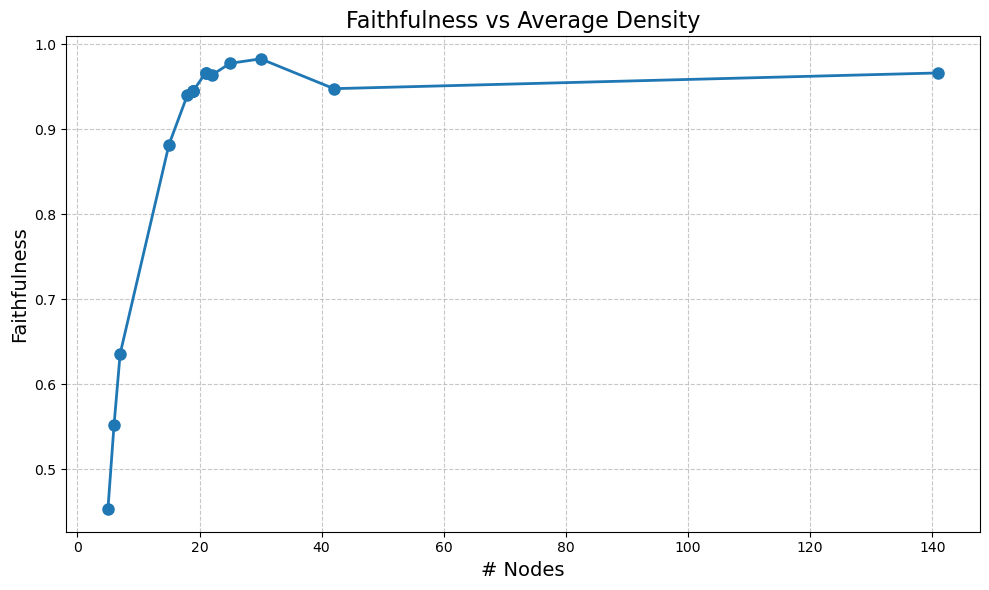

In [93]:
plt.figure(figsize=(10, 6))
plt.plot(nnodes, faithfulness, marker='o', linestyle='-', linewidth=2, markersize=8)

# Add grid for better readability
plt.grid(visible=True, linestyle='--', alpha=0.7)

# Highlight data points
# for x, y in zip(nnodes, faithfulness):
#     plt.scatter(x, y, color='red', edgecolor='black', zorder=5)
#     plt.text(x, y + 0.02, f'({x:.2f}, {y:.2f})', fontsize=9, ha='center')

# Add labels and title
plt.xlabel("# Nodes", fontsize=14)
plt.ylabel("Faithfulness", fontsize=14)
plt.title("Faithfulness vs Average Density", fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()

# Completeness test

## Full model + sae 

In [42]:
for sae in saes:
    sae.mask = SparseMask(sae.cfg.d_sae, 1.0, seq_len=example_length, distinct_l1=1.0).to(device)

def eval_logit_diff(batch, clean_labels, corr_labels, ratio_trained=10):
    for sae in saes:
        sae.mask.ratio_trained = ratio_trained
    logits = model.run_with_hooks(
        batch, 
        return_type="logits", 
        fwd_hooks=build_hooks_list(batch, use_mask=True, mean_mask=True, binarize_mask=True)
        )
    return logit_diff_fn(logits, clean_labels, corr_labels)

with torch.no_grad():
    model_logit_diff = eval_logit_diff(clean_tokens[-1], clean_label_tokens[-1], corr_label_tokens[-1]).item()
    print("Logit Diff:", model_logit_diff)
    cleanup_cuda()


Logit Diff: 3.664247512817383


## circuit

In [43]:
# Load masks before inference or further training
sparsity_multiplier = 0.14500000000000002
for idx, sae in enumerate(saes):
    mask_path = f"masks/sva/rc/{str(sparsity_multiplier)}_run/sae_mask_{idx}.pt"
    state_dict = torch.load(mask_path)
    sae.mask.load_state_dict(state_dict)
    print(f"Loaded mask for SAE {idx} from {mask_path}")

with torch.no_grad():
    circuit_logit_diff = eval_logit_diff(clean_tokens[-1], clean_label_tokens[-1], corr_label_tokens[-1]).item()
    print("Logit Diff:", circuit_logit_diff)
    cleanup_cuda()

/tmp/ipykernel_2102784/3619685325.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(mask_path)


Loaded mask for SAE 0 from masks/sva/rc/0.14500000000000002_run/sae_mask_0.pt
Loaded mask for SAE 1 from masks/sva/rc/0.14500000000000002_run/sae_mask_1.pt
Loaded mask for SAE 2 from masks/sva/rc/0.14500000000000002_run/sae_mask_2.pt
Loaded mask for SAE 3 from masks/sva/rc/0.14500000000000002_run/sae_mask_3.pt
Logit Diff: 3.2237625122070312


In [47]:
bdir = f"masks/sva/rc/{str(sparsity_multiplier)}_run/{str(sparsity_multiplier)}_run.json"
with open(bdir, 'r') as file:
    mask_dict = json.load(file)
mask_dict

{'blocks.7.hook_resid_post': [9152],
 'blocks.14.hook_resid_post': [5082, 9224],
 'blocks.21.hook_resid_post': [13730,
  7957,
  12577,
  170,
  209,
  865,
  4297,
  4714,
  6937,
  9502,
  10849,
  11008],
 'blocks.40.hook_resid_post': [520,
  1155,
  1433,
  1452,
  1743,
  2235,
  2488,
  2664,
  2693,
  2820,
  3111,
  3510,
  3764,
  3765,
  4330,
  4661,
  4843,
  6013,
  6214,
  6426,
  6574,
  6851,
  7776,
  7788,
  8003,
  8502,
  8583,
  9294,
  10455,
  10941,
  11314,
  11654,
  12905,
  13582,
  13762,
  14988,
  15427,
  15600,
  16048,
  16098],
 'total_density': 55,
 'avg_density': 13.75,
 'ce_loss': 4.722005367279053,
 'logit_diff': 3.2237625122070312,
 'faithfulness': 0.9174049496650696}

## Subset ablation test

In [58]:
import torch

# Number of elements to remove from the last dimension
num_remove = 5

# Number of batches to process
num_batches = 3  # Adjust this as needed
batch_size = 16  # Batch size for processing

# Remove random subsets of the mask along the [-1] dimension
def get_indices_to_remove(mask, num_remove):
    active_indices = (mask > 0).nonzero(as_tuple=True)[-1]  # Get indices of active elements in the last dimension
    if len(active_indices) < num_remove:
        raise ValueError("Not enough active elements to remove.")
    indices_to_remove = active_indices[torch.randperm(len(active_indices))[:num_remove]].to(mask.device)  # Move to the same device
    return indices_to_remove

def apply_subset_removal(mask, indices_to_remove):
    indices_to_remove = indices_to_remove.to(mask.device)  # Ensure indices are on the same device
    modified_mask = mask.clone()
    modified_mask.index_fill_(-1, indices_to_remove, -1.9455)  # Set selected elements to 0
    return modified_mask

In [59]:
ind_temp =  get_indices_to_remove(saes[1].mask.mask.data, 1)
ind_temp

tensor([5082], device='cuda:0')

In [60]:
mod_mask = apply_subset_removal(saes[1].mask.mask.data, ind_temp)
print(mod_mask[:, 9224])
print(mod_mask[:, 5082])

tensor([-1.9455, -1.9455, -1.9455,  1.5002, -1.9931, -1.9455, -1.9384],
       device='cuda:0')
tensor([-1.9455, -1.9455, -1.9455, -1.9455, -1.9455, -1.9455, -1.9455],
       device='cuda:0')


In [62]:
saes[1].mask.mask.data[:, 5082]

tensor([-1.9455, -1.9455,  2.4687, -1.9455, -1.9455, -1.6176, -1.9176],
       device='cuda:0')

In [65]:
random_k_results = []
for i in range(5):
    num_remove = [0, 0, 4, 10]
    indices_rem_list = []
    for ind, sae in enumerate(saes):
        # Get indices to remove based on the original mask
        indices_rem_list.append(get_indices_to_remove(sae.mask.mask.data, num_remove[ind]))
    random_k_results.append({"knockout_indices": indices_rem_list})
print(random_k_results)

[{'knockout_indices': [tensor([], device='cuda:0', dtype=torch.int64), tensor([], device='cuda:0', dtype=torch.int64), tensor([ 9502,   170, 10849,  4297], device='cuda:0'), tensor([ 8502,  4661,  2235,  8003,  2664, 11654, 10455,  6574,  2488, 16098],
       device='cuda:0')]}, {'knockout_indices': [tensor([], device='cuda:0', dtype=torch.int64), tensor([], device='cuda:0', dtype=torch.int64), tensor([12577, 10849,  4297, 13730], device='cuda:0'), tensor([11314,  3764, 13582,  7788,  1155, 10455,  3111,  3765, 10941,  6013],
       device='cuda:0')]}, {'knockout_indices': [tensor([], device='cuda:0', dtype=torch.int64), tensor([], device='cuda:0', dtype=torch.int64), tensor([13730,   865, 11008, 10849], device='cuda:0'), tensor([ 6013,  1452, 13582, 12905,  3764,  4661,  2693,  2664,  6214, 11654],
       device='cuda:0')]}, {'knockout_indices': [tensor([], device='cuda:0', dtype=torch.int64), tensor([], device='cuda:0', dtype=torch.int64), tensor([7957, 4297,  170,  209], device='cud

In [69]:
# Evaluate F(C \ K) and F(M \ K) for N batches
num_batches = 3
for rand_ind, k_results in enumerate(random_k_results):
    for case in ['circuit', 'model']:
        total_knock_logit_diff = 0.0
        for batch_idx in range(num_batches):
            sparsity_multiplier = 0.14500000000000002
            with torch.no_grad():
                for ind, sae in enumerate(saes):
                    if case == 'circuit':
                        mask_path = f"masks/sva/rc/{str(sparsity_multiplier)}_run/sae_mask_{ind}.pt"
                        state_dict = torch.load(mask_path)
                        sae.mask.load_state_dict(state_dict)
                    else:
                        sae.mask = SparseMask(sae.cfg.d_sae, 1.0, seq_len=example_length, distinct_l1=1.0).to(device)
                    sae.mask.mask.data = apply_subset_removal(sae.mask.mask.data, k_results['knockout_indices'][ind]).to(device)
                logit_diff = eval_logit_diff(clean_tokens[-batch_idx], clean_label_tokens[-batch_idx], corr_label_tokens[-batch_idx]).item()
                total_knock_logit_diff += logit_diff
                cleanup_cuda()
        # Average logit difference for the case
        avg_knock_logit_diff = total_knock_logit_diff / num_batches
        if case == 'circuit':
            print(f"Random set {rand_ind}, F(C \ K): {avg_knock_logit_diff}")
            random_k_results[rand_ind]['F_C_K'] = avg_knock_logit_diff
        else:
            print(f"Random set {rand_ind}, F(M \ K): {avg_knock_logit_diff}")
            random_k_results[rand_ind]['F_M_K'] = avg_knock_logit_diff

/tmp/ipykernel_2102784/295143282.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(mask_path)


Random set 0, F(C \ K): 2.9093210697174072
Random set 0, F(M \ K): 2.7343018849690757
Random set 1, F(C \ K): 0.23771830399831137
Random set 1, F(M \ K): 1.5550076166788738
Random set 2, F(C \ K): 0.28947647412618
Random set 2, F(M \ K): 0.8046261469523112
Random set 3, F(C \ K): 1.1134881178538005
Random set 3, F(M \ K): 1.1853818893432617
Random set 4, F(C \ K): 0.1393883228302002
Random set 4, F(M \ K): 0.7403132915496826


In [67]:
clean_tokens[-num_batches].shape

torch.Size([16, 7])

In [70]:
indices_rem_list_full = []
for ind, sae in enumerate(saes):
    # Get indices to remove based on the original mask
    indices_rem_list_full.append(torch.tensor(mask_dict[f"blocks.{layers[ind]}.hook_resid_post"]))
indices_rem_list_full

[tensor([9152]),
 tensor([5082, 9224]),
 tensor([13730,  7957, 12577,   170,   209,   865,  4297,  4714,  6937,  9502,
         10849, 11008]),
 tensor([  520,  1155,  1433,  1452,  1743,  2235,  2488,  2664,  2693,  2820,
          3111,  3510,  3764,  3765,  4330,  4661,  4843,  6013,  6214,  6426,
          6574,  6851,  7776,  7788,  8003,  8502,  8583,  9294, 10455, 10941,
         11314, 11654, 12905, 13582, 13762, 14988, 15427, 15600, 16048, 16098])]

In [72]:
for case in ['circuit', 'model']:
    total_knock_logit_diff = 0.0
    for batch_idx in range(num_batches):
        sparsity_multiplier = 0.14500000000000002
        with torch.no_grad():
            for ind, sae in enumerate(saes):
                if case == 'circuit':
                    mask_path = f"masks/sva/rc/{str(sparsity_multiplier)}_run/sae_mask_{ind}.pt"
                    state_dict = torch.load(mask_path)
                    sae.mask.load_state_dict(state_dict)
                else:
                    sae.mask = SparseMask(sae.cfg.d_sae, 1.0, seq_len=example_length, distinct_l1=1.0).to(device)
                sae.mask.mask.data = apply_subset_removal(sae.mask.mask.data, indices_rem_list_full[ind]).to(device)
            logit_diff = eval_logit_diff(clean_tokens[-batch_idx], clean_label_tokens[-batch_idx], corr_label_tokens[-batch_idx]).item()
            total_knock_logit_diff += logit_diff
            cleanup_cuda()
    # Average logit difference for the case
    avg_knock_logit_diff = total_knock_logit_diff / num_batches
    if case == 'circuit':
        print(f"full_circ_knock_circ F(C \ K): {avg_knock_logit_diff}")
        full_circ_knock_circ = avg_knock_logit_diff
    else:
        print(f" full_circ_knock_model F(M \ K): {avg_knock_logit_diff}")
        full_circ_knock_model = avg_knock_logit_diff

/tmp/ipykernel_2102784/53303709.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(mask_path)


full_circ_knock_circ F(C \ K): -0.04189920425415039
 full_circ_knock_model F(M \ K): -0.0016938447952270508


In [73]:
labels = ['Null Set']
for i in range(5):
    labels.append(f"Random Set {i}")
labels.append('Full Circuit Removal')

In [74]:
xy = [(circuit_logit_diff, model_logit_diff)]
for rand_ind, k_results in enumerate(random_k_results):
    xy.append((k_results['F_C_K'], k_results['F_M_K']))
xy.append((full_circ_knock_circ, full_circ_knock_model))
xy

[(3.2237625122070312, 3.664247512817383),
 (2.9093210697174072, 2.7343018849690757),
 (0.23771830399831137, 1.5550076166788738),
 (0.28947647412618, 0.8046261469523112),
 (1.1134881178538005, 1.1853818893432617),
 (0.1393883228302002, 0.7403132915496826),
 (-0.04189920425415039, -0.0016938447952270508)]

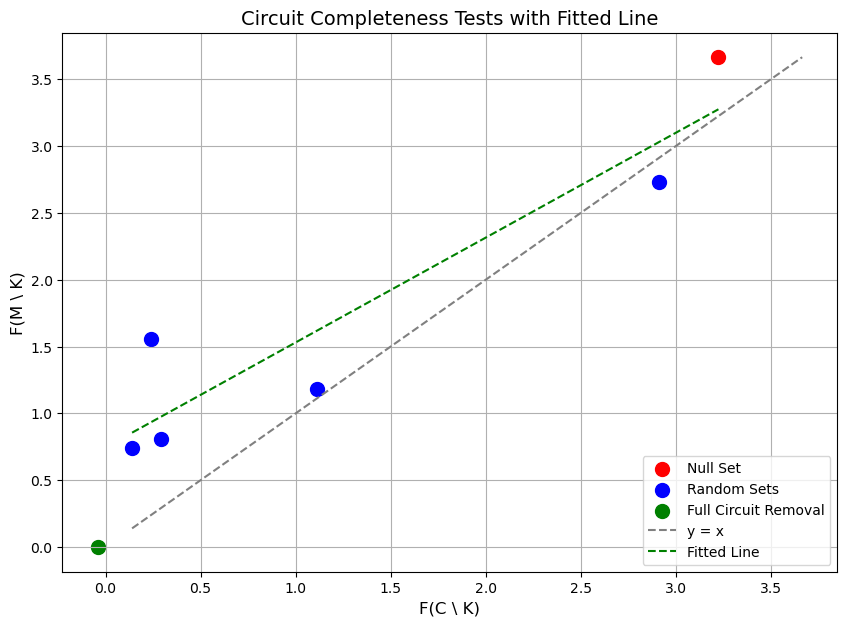

In [75]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
# Extract x and y values
# Separate the data into two groups
# Separate the data into two groups
null_set_xy = xy[0]
random_sets_xy = xy[1:-1]
full_circ_rem = xy[-1]

# Extract x and y values for linear regression
all_x = [point[0] for point in xy[:-1]]
all_y = [point[1] for point in xy[:-1]]

# Fit a linear regression model
regressor = LinearRegression()
all_x_reshaped = np.array(all_x).reshape(-1, 1)  # Reshape for sklearn
regressor.fit(all_x_reshaped, all_y)

# Generate points for the fitted line
fitted_x = np.linspace(min(all_x), max(all_x), 100)
fitted_y = regressor.predict(fitted_x.reshape(-1, 1))

# Extract x and y values for each group
null_set_x, null_set_y = null_set_xy
random_x = [point[0] for point in random_sets_xy]
random_y = [point[1] for point in random_sets_xy]
full_circ_x, full_circ_y = full_circ_rem
# Plot
plt.figure(figsize=(10, 7))

# Null set
plt.scatter(null_set_x, null_set_y, color='red', label='Null Set', s=100)

# Random sets
plt.scatter(random_x, random_y, color='blue', label='Random Sets', s=100)

# Full circuit removal
plt.scatter(full_circ_x, full_circ_y, color='green', label='Full Circuit Removal', s=100)

# Add reference line y = x
x_line = [min([null_set_x] + random_x + [null_set_y] + random_y), max([null_set_x] + random_x + [null_set_y] + random_y)]
plt.plot(x_line, x_line, linestyle="--", color="gray", label="y = x")

# Add fitted regression line
plt.plot(fitted_x, fitted_y, linestyle="--", color="green", label="Fitted Line")

# Customize plot
plt.title("Circuit Completeness Tests with Fitted Line", fontsize=14)
plt.xlabel("F(C \\ K)", fontsize=12)
plt.ylabel("F(M \\ K)", fontsize=12)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)

# Show plot
plt.show()


# Overlap and stability 

In [76]:
num_runs = 10
start = 0.05
end = 1
step = (end-start)/num_runs
nnodes = []
faithfulness = []

for i in range(num_runs):
    sparsity_multiplier = start + i*step
    bdir = f"masks/sva/rc/{str(sparsity_multiplier)}_run/{str(sparsity_multiplier)}_run.json"
    # load the dict 
    with open(bdir, 'r') as file:
        mask_dict = json.load(file)
    print(mask_dict)
    # nnodes.append(mask_dict['total_density'])
    # faithfulness.append(mask_dict['faithfulness'])
    

{'blocks.7.hook_resid_post': [9152, 4146, 4148, 6415, 14287], 'blocks.14.hook_resid_post': [5082, 9224, 736, 2887, 6570, 10343, 10818, 11236, 14791], 'blocks.21.hook_resid_post': [972, 7105, 7957, 13730, 7957, 12577, 13979, 5533, 6293, 13371, 170, 209, 510, 865, 1181, 3687, 4000, 4297, 4714, 5141, 5704, 6333, 6937, 7250, 7306, 7723, 7887, 8366, 8735, 9103, 9502, 9591, 9633, 10036, 10309, 10502, 10837, 10849, 11008, 11847, 12057, 12585, 12667, 13614, 13702, 15950], 'blocks.40.hook_resid_post': [23, 520, 662, 1035, 1155, 1433, 1452, 1743, 1956, 1980, 2235, 2285, 2488, 2664, 2693, 2820, 3111, 3400, 3506, 3510, 3554, 3764, 3765, 3790, 4330, 4570, 4661, 4740, 4843, 4985, 5312, 5516, 5610, 5909, 5988, 6013, 6214, 6302, 6403, 6426, 6574, 6818, 6851, 7417, 7651, 7776, 7788, 8003, 8019, 8502, 8583, 8958, 9294, 9696, 10267, 10455, 10604, 10702, 10941, 11051, 11314, 11367, 11524, 11654, 12118, 12333, 12349, 12444, 12905, 12923, 13082, 13263, 13386, 13582, 13762, 13776, 14357, 14466, 14571, 14725,

In [80]:
from itertools import combinations
num_runs = 10
start = 0.05
end = 1
step = (end - start) / num_runs

# Load all dictionaries
masks = []
for i in range(num_runs):
    sparsity_multiplier = start + i * step
    bdir = f"masks/sva/rc/{str(sparsity_multiplier)}_run/{str(sparsity_multiplier)}_run.json"
    with open(bdir, 'r') as file:
        masks.append(json.load(file))
    
rev_mask = list(reversed(masks))

In [81]:
from itertools import combinations
for small_idx, big_idx in combinations(range(num_runs), 2):
    # print(f"Comparing {small_idx} and {big_idx}")
    print(f"Comparing {rev_mask[small_idx]['total_density']} and {rev_mask[big_idx]['total_density']}")

Comparing 12 and 13
Comparing 12 and 17
Comparing 12 and 19
Comparing 12 and 22
Comparing 12 and 23
Comparing 12 and 29
Comparing 12 and 34
Comparing 12 and 55
Comparing 12 and 148
Comparing 13 and 17
Comparing 13 and 19
Comparing 13 and 22
Comparing 13 and 23
Comparing 13 and 29
Comparing 13 and 34
Comparing 13 and 55
Comparing 13 and 148
Comparing 17 and 19
Comparing 17 and 22
Comparing 17 and 23
Comparing 17 and 29
Comparing 17 and 34
Comparing 17 and 55
Comparing 17 and 148
Comparing 19 and 22
Comparing 19 and 23
Comparing 19 and 29
Comparing 19 and 34
Comparing 19 and 55
Comparing 19 and 148
Comparing 22 and 23
Comparing 22 and 29
Comparing 22 and 34
Comparing 22 and 55
Comparing 22 and 148
Comparing 23 and 29
Comparing 23 and 34
Comparing 23 and 55
Comparing 23 and 148
Comparing 29 and 34
Comparing 29 and 55
Comparing 29 and 148
Comparing 34 and 55
Comparing 34 and 148
Comparing 55 and 148


In [82]:
# Define a function to calculate overlap for two dictionaries
def calculate_overlap(small_dict, big_dict):
    overlaps = {}
    for block, small_elements in small_dict.items():
        if block in big_dict and block.startswith("blocks"):
            big_elements = big_dict[block]
            overlap_count = len(set(small_elements) & set(big_elements))
            total_small = len(small_elements)
            overlaps[block] = overlap_count / total_small if total_small > 0 else 0
    return overlaps

# Calculate overlap for all combinations of smaller and larger dictionaries
results = []
for small_idx, big_idx in combinations(range(num_runs), 2):
    small_dict = rev_mask[small_idx]
    big_dict = rev_mask[big_idx]
    overlap_result = calculate_overlap(small_dict, big_dict)
    results.append({
        "small_index": small_idx,
        "big_index": big_idx,
        "overlap": overlap_result
    })

# Display results
import pandas as pd

overlap_df = pd.DataFrame([
    {
        "small_index": result["small_index"],
        "big_index": result["big_index"],
        **result["overlap"]
    }
    for result in results
])
overlap_df

,small_index,big_index,blocks.7.hook_resid_post,blocks.14.hook_resid_post,blocks.21.hook_resid_post,blocks.40.hook_resid_post
0,0,1,1.0,1.0,1.0,1.000000
1,0,2,1.0,1.0,1.0,1.000000
2,0,3,1.0,1.0,1.0,1.000000
3,0,4,1.0,1.0,1.0,1.000000
4,0,5,1.0,1.0,1.0,1.000000
5,0,6,1.0,1.0,1.0,1.000000
6,0,7,1.0,1.0,1.0,1.000000
7,0,8,1.0,1.0,1.0,1.000000
8,0,9,1.0,1.0,1.0,1.000000
9,1,2,1.0,1.0,1.0,1.000000


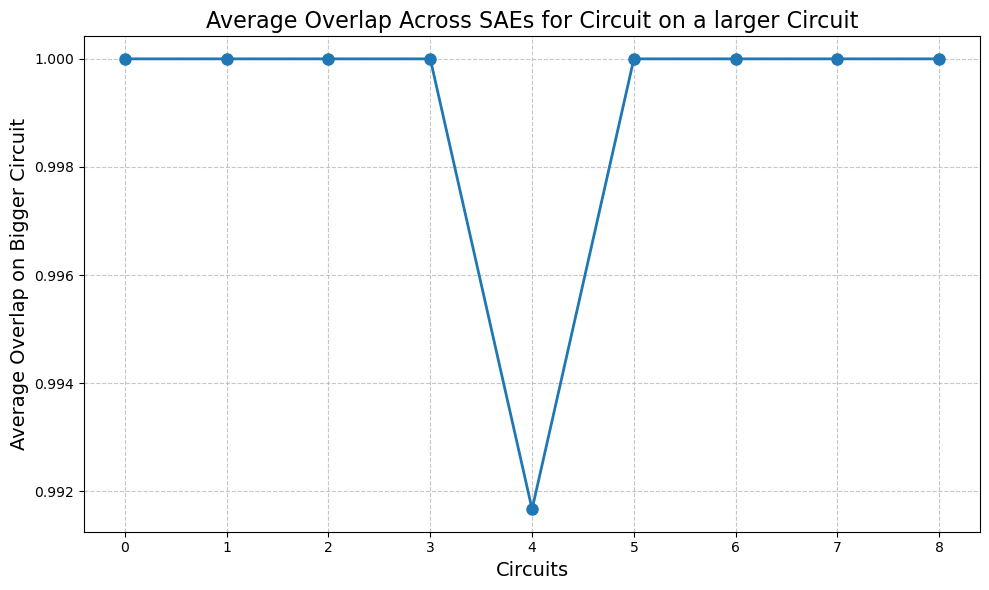

In [85]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming `results` contains the overlap data calculated earlier
# Extracting and averaging overlap values for each `small_index`
averaged_overlaps = {}

for result in results:
    small_index = result["small_index"]
    overlap_values = list(result["overlap"].values())  # Get overlap values for all blocks
    averaged_overlap = sum(overlap_values) / len(overlap_values) if overlap_values else 0
    if small_index not in averaged_overlaps:
        averaged_overlaps[small_index] = []
    averaged_overlaps[small_index].append(averaged_overlap)

# Compute the final average for each `small_index`
final_averages = {k: sum(v) / len(v) for k, v in averaged_overlaps.items()}

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(
    list(final_averages.keys()),
    list(final_averages.values()),
    marker='o',
    linestyle='-',
    linewidth=2,
    markersize=8,
)

# Add grid, labels, and title
plt.grid(visible=True, linestyle='--', alpha=0.7)
plt.xlabel("Circuits", fontsize=14)
plt.ylabel("Average Overlap on Bigger Circuit", fontsize=14)
plt.title("Average Overlap Across SAEs for Circuit on a larger Circuit", fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()


# IG

In [22]:
import torch.nn.functional as F
def get_ig_effect_batch(sae_id, token_dataset, corr_token_dataset, labels_dataset, corr_labels_dataset):
    # ig_batch_size = 4

    def logitfn_cache(tokens):
        logits =  model.run_with_hooks(
            tokens, 
            return_type="logits", 
            fwd_hooks=build_hooks_list(tokens, use_mask=use_mask, mean_mask=mean_mask, cache_sae_activations=True)
            )
        cached_activations = [sae.feature_acts for sae in saes]
        return logits, cached_activations
    
    # cache_sae_logitfn = build_sae_logitfn(cache_sae_activations=True)

    # def cache_sae_activations(tokens):
    #     logits = cache_sae_logitfn(tokens)
    #     cached_activations = [sae.feature_acts for sae in saes]
    #     return logits, cached_activations
    # def build_sae_logitfn(**kwargs):
    # def logitfn(tokens):
    #     return model.run_with_hooks(
    #         tokens, 
    #         return_type="logits", 
    #         fwd_hooks=build_hooks_list(tokens, **kwargs)
    #         )
    # return logitfn

    def sae_continue_cache_logitfn(tokens, sae_idx, cache, **kwargs):
        logits = model.run_with_hooks(
            tokens, 
            return_type="logits", 
            fwd_hooks=build_hooks_list(tokens, fake_activations=(sae_idx, cache),**kwargs)
            )
        # logitfn = build_sae_logitfn(fake_activations=(sae_idx, cache), **kwargs)
        return logits

    # correct_tokenized = batch.correct_tokenized
    # traceback_tokenized = batch.error_tokenized
    # correct_labels = batch.correct_labels
    # traceback_labels = batch.error_labels

    # run a forward pass on the correct and error examples
    with torch.no_grad():
        _, clean_activations = logitfn_cache(token_dataset)
        _, corr_activations = logitfn_cache(corr_token_dataset)


    sae = saes[sae_id]
    sae_clean_acts = clean_activations[sae_id]
    sae_corr_acts = corr_activations[sae_id]

    steps = 10
    ratios = [i/steps for i in range(steps)] # we skip the last one b/c we are integrating, obv
        
    effects = []
    for ratio in ratios:
        interpolation = (sae_clean_acts * (1-ratio) + sae_corr_acts * (ratio)).requires_grad_(True)
        interpolation.retain_grad()
        interpolated_out = sae_continue_cache_logitfn(
            token_dataset, sae.cfg.hook_layer, interpolation,
        )
        answer_logits = interpolated_out[..., -1, :] # get the logits of the last tokens
        # get the logprob on the inner most dimension
        answer_logprobs = F.log_softmax(answer_logits, dim=-1)

        clean_logprobs = answer_logprobs[..., torch.arange(answer_logprobs.shape[-2]), labels_dataset]
        corr_logprobs = answer_logprobs[..., torch.arange(answer_logprobs.shape[-2]), corr_labels_dataset]
        metric = torch.sum(clean_logprobs - corr_logprobs)
        metric.backward()

        counterfactual_delta = sae_clean_acts - sae_corr_acts
        
        effect = (interpolation.grad * counterfactual_delta).mean(dim=0)

        effects.append(effect)

    effects = torch.stack(effects)
    clear_memory()
    return effects.mean(dim=0)


In [23]:
clean_tokens.shape

torch.Size([625, 16, 7])

In [24]:
def get_sae_ig_effect(sae_id, num_batches, clean_tokens, corr_tokens, clean_label_tokens, corr_label_tokens):
    effect_batches = []
    for i in tqdm(range(0, num_batches)):
        clean_batch = clean_tokens[i]  
        corr_batch = corr_tokens[i]
        clean_label_batch = clean_label_tokens[i]
        corr_label_batch = corr_label_tokens[i]
        effect_batches.append(get_ig_effect_batch(sae_id, clean_batch, corr_batch, clean_label_batch, corr_label_batch))
    return torch.stack(effect_batches).mean(dim=0)

In [25]:
def get_all_sae_ig_effects(num_batches, clean_tokens, corr_tokens, clean_label_tokens, corr_label_tokens):
    for i in range(len(saes)):
        ig_effect = get_sae_ig_effect(i, num_batches, clean_tokens, corr_tokens, clean_label_tokens, corr_label_tokens)
        saes[i].igmask = IGMask(ig_effect)
        

In [26]:
get_all_sae_ig_effects(15, clean_tokens, corr_tokens, clean_label_tokens, corr_label_tokens)

100%|██████████| 15/15 [01:04<00:00,  4.30s/it]


In [94]:
torch.count_nonzero(saes[1].igmask.ig_scores)

tensor(4258, device='cuda:0')

In [39]:
masks = produce_ig_binary_masks(threshold=0.3)

In [29]:
masks.print_mask_statistics()

Statistics for mask 'blocks.7.hook_resid_post':
  - Shape: [7, 16384]
  - Total latents: 114688
  - Latents ON (mask=1): 1
  - Average ON per token: 0.1429

Statistics for mask 'blocks.14.hook_resid_post':
  - Shape: [7, 16384]
  - Total latents: 114688
  - Latents ON (mask=1): 2
  - Average ON per token: 0.2857

Statistics for mask 'blocks.21.hook_resid_post':
  - Shape: [7, 16384]
  - Total latents: 114688
  - Latents ON (mask=1): 2
  - Average ON per token: 0.2857

Statistics for mask 'blocks.40.hook_resid_post':
  - Shape: [7, 16384]
  - Total latents: 114688
  - Latents ON (mask=1): 4
  - Average ON per token: 0.5714



In [46]:
torch.nonzero(masks.masks[0])

tensor([[   2, 9152]], device='cuda:0')

In [ ]:
iglogitfn  = build_sae_logitfn(circuit_mask=masks, mean_mask=True)
# model.run_with_hooks(
#             tokens, 
#             return_type="logits", 
#             fwd_hooks=build_hooks_list(tokens, **kwargs)
#             )


In [43]:
saes[0].igmask.get_threshold_info(0.0)

{'total_latents': tensor(5885., device='cuda:0'),
 'avg_latents_per_tok': tensor(840.7143, device='cuda:0'),
 'latents_per_tok': tensor([   0.,    0., 1302.,  512.,  275., 1916., 1880.], device='cuda:0')}

In [30]:
def pp(x):
    keys = list(x.keys())
    values = list(x.values())
    for i in range(len(keys)):
        print(f"{keys[i]}: {values[i]}")

In [31]:
ig_masks = produce_ig_binary_masks(threshold=0.3)

In [32]:
threshold = 0.3
sum = 0
for sae in saes:
    print("layer:", sae.cfg.hook_layer)
    latents_in_sae = sae.igmask.get_threshold_info(threshold)['total_latents'].item()
    sum += latents_in_sae
    print(latents_in_sae)

print("total", sum)

print("="*40)
with torch.no_grad():
    ig_logits = model.run_with_hooks(
            clean_tokens[-1], 
            return_type="logits", 
            fwd_hooks=build_hooks_list(clean_tokens[-1], ig_mask_threshold=threshold, mean_mask=True)
            )
    ld = logit_diff_fn(ig_logits, clean_label_tokens[-1], corr_label_tokens[-1])
    print(ld)
    # ig_logitfn = build_sae_logitfn(ig_mask_threshold=threshold, mean_mask=True)
    # metrics = sanity_check_model_performance(ig_logitfn)
    # top1_correct_avg = (metrics['top1_correct'] + metrics['top1_error'])/2
    # ce_avg = (metrics['ce_loss_correct'] + metrics['ce_loss_error'])/2
    # pp(metrics)
    # print("avg top1 correct", top1_correct_avg)
    # print("avg CE loss", ce_avg)

layer: 7
1.0
layer: 14
2.0
layer: 21
2.0
layer: 40
4.0
total 9.0
tensor(2.6440, device='cuda:0')


In [38]:
avg_ig_ld = 0
threshold = 0.3
with torch.no_grad():
    for i in range(10):
        ig_logits = model.run_with_hooks(
                clean_tokens[-i], 
                return_type="logits", 
                fwd_hooks=build_hooks_list(clean_tokens[-i], ig_mask_threshold=threshold, mean_mask=True)
                )
        ld = logit_diff_fn(ig_logits, clean_label_tokens[-i], corr_label_tokens[-i])
        print(ld)
        avg_ig_ld += ld
        cleanup_cuda()
print("Average LD: ", avg_ig_ld / 10)
ig_ld = (avg_ig_ld / 10).item()

tensor(2.3567, device='cuda:0')
tensor(2.6440, device='cuda:0')
tensor(2.4247, device='cuda:0')
tensor(2.1398, device='cuda:0')
tensor(2.2635, device='cuda:0')
tensor(2.5484, device='cuda:0')
tensor(2.3490, device='cuda:0')
tensor(2.3447, device='cuda:0')
tensor(2.4760, device='cuda:0')
tensor(2.3131, device='cuda:0')
Average LD:  tensor(2.3860, device='cuda:0')


In [35]:
modelsae_ld = (avg_logit_diff / 10).item()

In [37]:
modelsae_ld

3.5140016078948975

In [36]:
avg_ig_ld / (10*modelsae_ld) 

tensor(0.6790, device='cuda:0')

In [95]:
# Comparison:

def get_faithfulness(clean_tokens, clean_label_tokens, corr_label_tokens, mask, modelsae_ld):
    avg_ig_ld = 0
    with torch.no_grad():
        for i in range(10):
            ig_logits = model.run_with_hooks(
                    clean_tokens[-i], 
                    return_type="logits", 
                    fwd_hooks=build_hooks_list(clean_tokens[-i], circuit_mask=mask, mean_mask=True)
                    )
            ld = logit_diff_fn(ig_logits, clean_label_tokens[-i], corr_label_tokens[-i])
            avg_ig_ld += ld
            cleanup_cuda()
    avg_ig = (avg_ig_ld / 10).item()
    faithfulness_ratio = avg_ig/modelsae_ld
    return faithfulness_ratio

def get_faithfulness_frontier(mask_producer_fn, start_threshold, end_threshold, clean_tokens, clean_label_tokens, corr_label_tokens, modelsae_ld, steps = 10, modify_fn = lambda x: x):
    thresholds = []
    delta = (end_threshold - start_threshold) / steps

    # apply a linear function such that the linear_map(modify_fn(start_threshold)) = start_threshold
    # and linear_map(modify_fn(end_threshold)) = end_threshold

    def linear_map(x):
        mod_start = modify_fn(start_threshold)
        mod_end = modify_fn(end_threshold)
        return (x - mod_start) / (mod_end - mod_start) * (end_threshold - start_threshold) + start_threshold
    
    mf = lambda x: linear_map(modify_fn(x))
    


    for i in range(steps):
        thresholds.append(
            mf(start_threshold + i*delta)
            )
    
    faithfulness_scores = []
    for threshold in tqdm(thresholds):
        mask = mask_producer_fn(threshold=threshold)
        num_latents = mask.get_num_latents()
        faithfulness_ratio = get_faithfulness(clean_tokens, clean_label_tokens, corr_label_tokens, mask, modelsae_ld
        )
        faithfulness_scores.append([num_latents, faithfulness_ratio])
    return faithfulness_scores        

ig_faithfulness_frontier = get_faithfulness_frontier(produce_ig_binary_masks, 0.01, 3, clean_tokens, clean_label_tokens, corr_label_tokens, modelsae_ld, steps=20, modify_fn=lambda x: x**4)


100%|██████████| 20/20 [01:25<00:00,  4.29s/it]


In [105]:
ig_faithfulness_frontier[9]

[18, 0.760039883868358]

In [108]:
thresholds = []
start_threshold = 0.01
end_threshold = 3
delta = (end_threshold - start_threshold) / 20
def linear_map(x):
        mod_start = modify_fn(start_threshold)
        mod_end = modify_fn(end_threshold)
        return (x - mod_start) / (mod_end - mod_start) * (end_threshold - start_threshold) + start_threshold
    
mf = lambda x: linear_map(modify_fn(x))
for i in range(20):
    thresholds.append(
        mf(start_threshold + i*delta)
        )
thresholds

[0.01,
 0.0184186877076412,
 0.04168803986710965,
 0.07980805647840535,
 0.1327787375415283,
 0.20060008305647845,
 0.28327209302325596,
 0.38079476744186064,
 0.4931681063122925,
 0.6203921096345517,
 0.762466777408638,
 0.9193921096345519,
 1.0911681063122927,
 1.2777947674418608,
 1.4792720930232561,
 1.6956000830564784,
 1.9267787375415286,
 2.172808056478406,
 2.4336880398671097,
 2.709418687707642]

In [109]:
thresholds[9]

0.6203921096345517

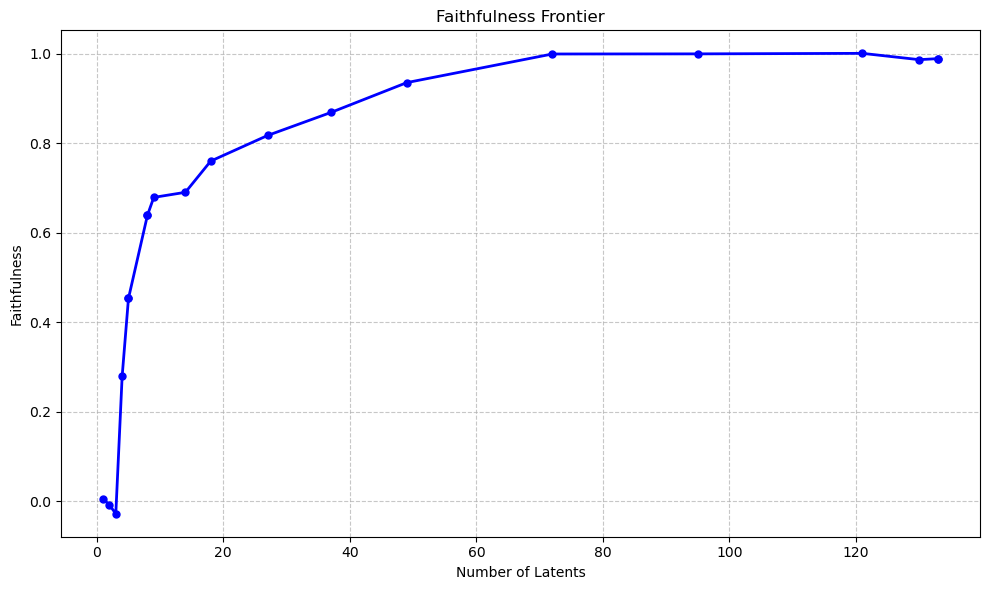

In [96]:

def plot_faithfulness_frontier(faithfulness_frontier):
    # Assuming faithfulness_frontier is your list of tuples
    # Example: faithfulness_frontier = [(10, 0.8), (20, 0.85), (30, 0.89), ...]

    # Unzip the tuples into separate lists for x and y coordinates
    num_latents, faithfulness = zip(*faithfulness_frontier)

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(num_latents, faithfulness, 'b.-', linewidth=2, markersize=10)

    # Add labels and title
    plt.xlabel('Number of Latents')
    plt.ylabel('Faithfulness')
    plt.title('Faithfulness Frontier')

    # Add grid for better readability
    plt.grid(True, linestyle='--', alpha=0.7)

    # Optionally, you can customize the axis ranges if needed
    # plt.xlim([min(num_latents), max(num_latents)])
    # plt.ylim([min(faithfulness), max(faithfulness)])

    # Display the plot
    plt.tight_layout()
    plt.show()
plot_faithfulness_frontier(ig_faithfulness_frontier)

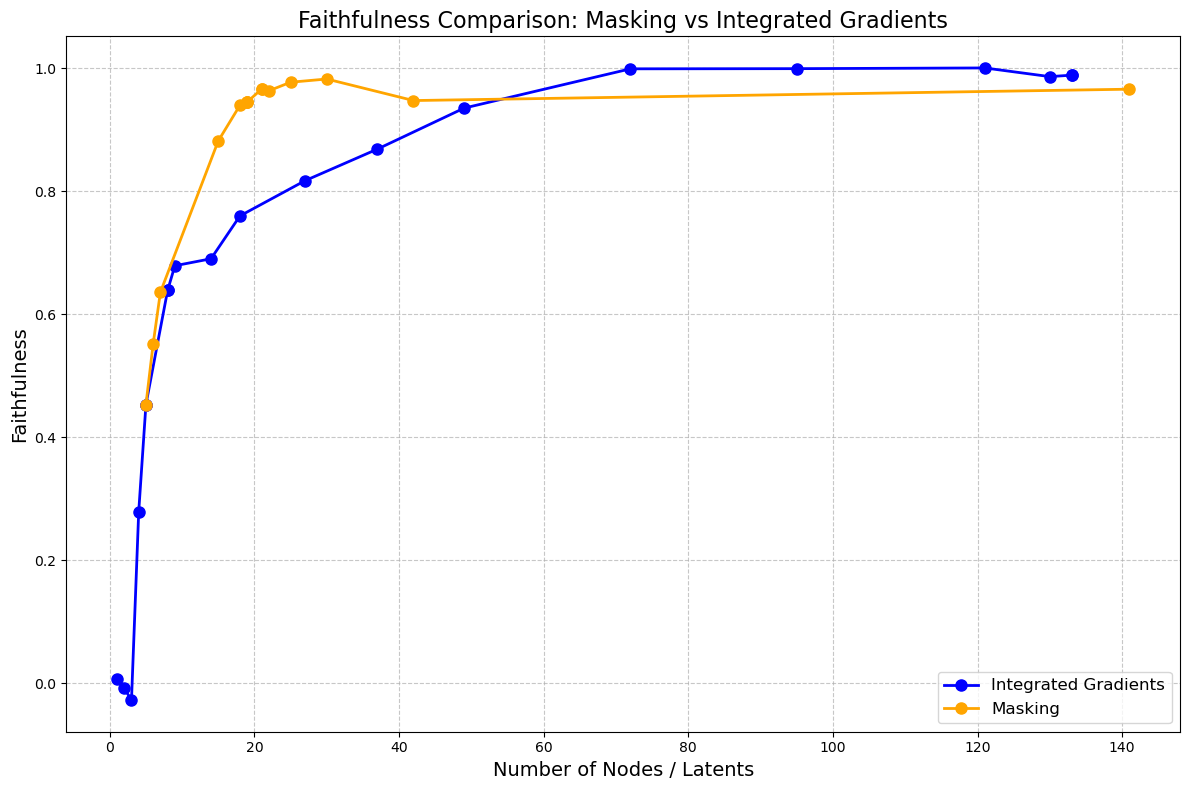

In [101]:
import matplotlib.pyplot as plt
import json

# Initialize variables
num_runs = 10
start = 0.05
end = 1
step = (end-start)/num_runs
nnodes = []
faithfulness = []
for i in range(num_runs):
    sparsity_multiplier = start + i*step
    bdir = f"masks/sva/rc/logit_diff_{str(sparsity_multiplier)}_run/{str(sparsity_multiplier)}_run.json"
    # load the dict 
    with open(bdir, 'r') as file:
        mask_dict = json.load(file)
    nnodes.append(mask_dict['total_density'])
    faithfulness.append(mask_dict['faithfulness'])

num_runs = 5
start_threshold = 1
end_threshold = 20 
modify_fn=lambda x: x**2

def linear_map(x):
        mod_start = modify_fn(start_threshold)
        mod_end = modify_fn(end_threshold)
        return (x - mod_start) / (mod_end - mod_start) * (end_threshold - start_threshold) + start_threshold
    
mf = lambda x: linear_map(modify_fn(x))
delta = (end_threshold - start_threshold) / num_runs

for i in range(num_runs):
    sparsity_multiplier = mf(start_threshold + i*delta)
    bdir = f"masks/sva/rc/logit_diff_{str(sparsity_multiplier)}_run/{str(sparsity_multiplier)}_run.json"
    # load the dict 
    with open(bdir, 'r') as file:
        mask_dict = json.load(file)
    nnodes.append(mask_dict['total_density'])
    faithfulness.append(mask_dict['faithfulness'])

# Unzip the tuples into separate lists for Integrated Gradients plot
num_latents, ig_faithfulness = zip(*ig_faithfulness_frontier)

# Create the combined plot
plt.figure(figsize=(12, 8))

# Plot "Integrated Gradients"
plt.plot(num_latents, ig_faithfulness, marker='o',linestyle='-', linewidth=2, markersize=8,  label='Integrated Gradients', color='blue')

# Plot "Masking"
plt.plot(nnodes, faithfulness, marker='o', linestyle='-', linewidth=2, markersize=8, label='Masking', color='orange')



# Add labels, legend, and title
plt.xlabel('Number of Nodes / Latents', fontsize=14)
plt.ylabel('Faithfulness', fontsize=14)
plt.title('Faithfulness Comparison: Masking vs Integrated Gradients', fontsize=16)
plt.legend(fontsize=12)

# Add grid for better readability
plt.grid(visible=True, linestyle='--', alpha=0.7)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


In [102]:
def save_igmask(igmask, file_path):
    """Save the IGMask instance to a file."""
    if not isinstance(igmask, IGMask):
        raise ValueError("The object to save must be an instance of IGMask.")

    # Save the ig_scores and any additional parameters if needed
    state_dict = {
        'ig_scores': igmask.ig_scores
    }
    
    # Create directory if it doesn't exist
    os.makedirs(os.path.dirname(file_path), exist_ok=True)

    # Save the state dictionary using PyTorch
    torch.save(state_dict, file_path)

for sae in saes:
    save_igmask(sae.igmask, f"masks/sva/rc/igmask_{sae.cfg.hook_layer}.pt")

In [70]:
(saes[3].mask.mask > 0).sum()

tensor(50, device='cuda:0')

In [82]:
actual_mask = {}
for sae in saes: 
    actual_mask[sae.cfg.hook_name] = torch.where(sae.mask.mask > 0)[1].tolist()
actual_mask

{'blocks.7.hook_resid_post': [9152, 4146, 14287],
 'blocks.14.hook_resid_post': [5082, 9224, 11236],
 'blocks.21.hook_resid_post': [7957,
  13730,
  7957,
  12577,
  170,
  209,
  865,
  3687,
  4297,
  4714,
  5141,
  6937,
  8735,
  9502,
  9591,
  10849,
  11008,
  12057,
  15950],
 'blocks.40.hook_resid_post': [23,
  520,
  1035,
  1155,
  1433,
  1452,
  1743,
  1980,
  2235,
  2285,
  2488,
  2664,
  2693,
  2820,
  3111,
  3510,
  3764,
  3765,
  4330,
  4661,
  4740,
  4843,
  6013,
  6214,
  6426,
  6574,
  6851,
  7776,
  7788,
  8003,
  8502,
  8583,
  9294,
  9696,
  10455,
  10702,
  10941,
  11051,
  11314,
  11654,
  12333,
  12905,
  13582,
  13762,
  14357,
  14988,
  15427,
  15600,
  16048,
  16098]}

In [83]:
# save the mask
json.dump(actual_mask, open("updated_01_run.json", "w"))

In [77]:
torch.where(saes[3].mask.mask > 0)[1]

tensor([   23,   520,  1035,  1155,  1433,  1452,  1743,  1980,  2235,  2285,
         2488,  2664,  2693,  2820,  3111,  3510,  3764,  3765,  4330,  4661,
         4740,  4843,  6013,  6214,  6426,  6574,  6851,  7776,  7788,  8003,
         8502,  8583,  9294,  9696, 10455, 10702, 10941, 11051, 11314, 11654,
        12333, 12905, 13582, 13762, 14357, 14988, 15427, 15600, 16048, 16098],
       device='cuda:0')

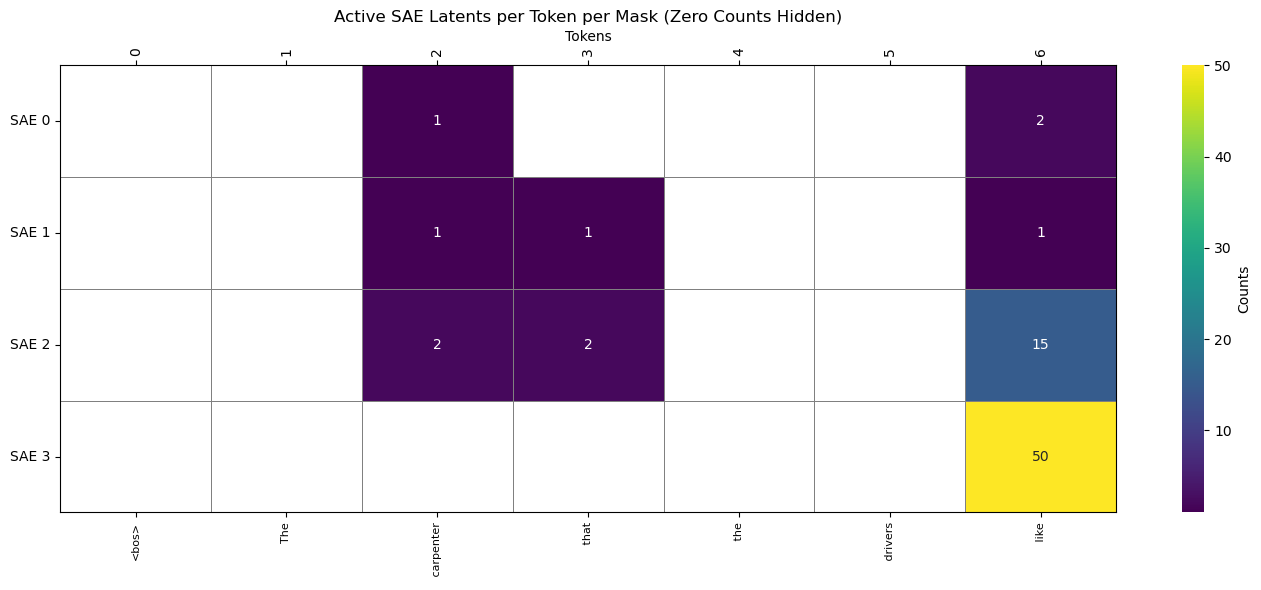

layer 0 latents: 3 🖕
layer 1 latents: 3 🖕
layer 2 latents: 19 🖕
layer 3 latents: 50 🖕
total # latents: 75 🖕


In [72]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm

# Assuming 'saes', 'model', and 'simple_dataset' are defined
tokens = model.to_str_tokens(clean_tokens[2][0])
num_masks = 4 # Number of masks you have
counts_per_mask = []
for mask_index in range(num_masks):
    testmask = saes[mask_index].mask.mask.data.clone()
    binarized = (testmask > 0.0).float()
    counts = []
    for i in range(len(tokens)):
        counts.append(torch.count_nonzero(binarized[i]).item())
    counts_per_mask.append(counts)

# Convert counts to a NumPy array
data = np.array(counts_per_mask) # Shape: (num_masks, num_tokens)

# Create a mask for zero values
zero_mask = data == 0

# Define a colormap
cmap = sns.color_palette("viridis", as_cmap=True)

# Plot the heatmap with the mask
plt.figure(figsize=(14, 6))
ax = sns.heatmap(
    data,
    annot=True,
    fmt='d',
    cmap=cmap,
    mask=zero_mask,
    cbar_kws={'label': 'Counts'},
    linewidths=0.5,
    linecolor='gray'
)

# Set x-axis labels to tokens
ax.set_xticks(np.arange(len(tokens)) + 0.5)
ax.set_xticklabels(tokens, rotation=90, fontsize=8)

# Add numeric indices above the chart
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(np.arange(len(tokens)) + 0.5)
ax2.set_xticklabels(np.arange(len(tokens)), rotation=90)  # Rotate indices 90 degrees
ax2.set_xlabel('Token Indices')

# Set y-axis labels to masks
ax.set_yticks(np.arange(num_masks) + 0.5)
ax.set_yticklabels([f'SAE {i}' for i in range(num_masks)], rotation=0)

plt.xlabel('Tokens')
plt.ylabel('SAE Number Active Latents')
plt.title('Active SAE Latents per Token per Mask (Zero Counts Hidden)')
plt.tight_layout()
plt.show()

# print the total # latents in the circuit
total_latents = 0
for i, sae in enumerate(saes):
    print(f"layer {i} latents: {torch.sum(sae.mask.mask > 0)} 🖕")
    total_latents += torch.sum(sae.mask.mask > 0)
print(f"total # latents: {total_latents} 🖕")


In [76]:
torch.nonzero((saes[0].mask.mask>0)[2])

tensor([[9152]], device='cuda:0')

# loss calc

In [59]:
logits = model(clean_tokens[21])
probs = F.softmax(logits[torch.arange(logits.shape[0]), -1], dim=-1)
prob_correct = probs[torch.arange(probs.shape[0]), clean_label_tokens[21]].mean().item()
max_prob_idxs = probs.argmax(dim=-1)
top1_acc = (max_prob_idxs == clean_label_tokens[21]).float().mean().item()
print(prob_correct, top1_acc)

0.04241183027625084 0.125


In [61]:
for sae in saes:
    sae.mask = SparseMask(sae.cfg.d_sae, 1.0, seq_len=7, distinct_l1=1.0).to(device)

logits = model.run_with_hooks(
        clean_tokens[21], 
        return_type="logits", 
        fwd_hooks=build_hooks_list(clean_tokens[21], use_mask=False, mean_mask=False) #, binarize_mask=True)
        )
probs = F.softmax(logits[torch.arange(logits.shape[0]), -1], dim=-1)
prob_correct = probs[torch.arange(probs.shape[0]), clean_label_tokens[21]].mean().item()
max_prob_idxs = probs.argmax(dim=-1)
top1_acc = (max_prob_idxs == clean_label_tokens[21]).float().mean().item()
print(prob_correct, top1_acc)

0.054300688207149506 0.1875


In [ ]:
def compute_token_probabilities(logits, labels):
    """Compute probabilities, logit differences, and CE loss for token predictions."""
    # Get probabilities for all tokens at the sequence positions
    probs = F.softmax(logits[torch.arange(logits.shape[0]), -1], dim=-1)
    
    # Calculate mean probabilities for correct and error tokens
    prob_correct = probs[torch.arange(probs.shape[0]), labels].mean().item()
    max_prob_idxs = probs.argmax(dim=-1)
    top1_acc = (max_prob_idxs == labels).float().mean().item()
    # prob_error = get_highest_other_prob(probs, labels).mean().item()
    
    # Calculate logit difference
    correct_logits = logits[torch.arange(logits.shape[0]), -1, labels]
    # error_logits = get_highest_other_logit(logits[torch.arange(logits.shape[0]), -1], labels)
    logit_diff = (correct_logits - error_logits).mean().item()
    
    # Calculate CE loss
    ce_loss = F.cross_entropy(
        logits[torch.arange(logits.shape[0]), -1], 
        labels
    ).item()
    
    return prob_correct, prob_error, logit_diff, top1_acc, ce_loss